In [1]:
import xarray as xr
import fsspec
import fv3fit
import os
import matplotlib.pyplot as plt
import numpy as np
import vcm
from vcm.catalog import catalog 
from vcm import DerivedMapping
import dask.diagnostics
import math
import cftime
import time
import fv3viz
import joblib
import intake
import pandas as pd
import json
import cartopy.crs as ccrs
from math import isclose


In [2]:
runs = {
  "baseline": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/baseline-trial2/fv3gfs_run",
    "alg": "baseline"
  },
  "prognostic": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-wind-vanilla-trial2/fv3gfs_run",
    "alg": "prognostic"
  },
  "prognostic-tq": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos2-vanilla-trial4/fv3gfs_run",
    "alg": "prognostic-tq"
  },
  "ocsvm-gamma-4_79-0.4": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-large-gamma-0.4-default-trial1/fv3gfs_run",
    "alg": "ocsvm",
    "gamma": 4/79,
    "cutoff": 0.4,
  },
  "ocsvm-gamma-4_79-0.2": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-large-gamma-0.2-default-trial1/fv3gfs_run",
    "alg": "ocsvm",
    "gamma": 4/79,
    "cutoff": 0.2,
  },
  # "ocsvm-gamma-4_79-0.2": {
  #   "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-large-gamma-0.2-default-trial1/fv3gfs_run",
  #   "alg": "ocsvm",
  #   "gamma": 4/79,
  #   "cutoff": 0.2
  # },
  "ocsvm-gamma-4_79-0": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-large-gamma-0-default-trial1/fv3gfs_run",
    "alg": "ocsvm",
    "gamma": 4/79,
    "cutoff": 0,
  },
  "ocsvm-gamma-4_79--0.5": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-large-gamma--0.5-default-trial1/fv3gfs_run",
    "alg": "ocsvm",
    "gamma": 4/79,
    "cutoff": -0.5,
  },
  "ocsvm-gamma-4_79--1": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-large-gamma--1-default-trial1/fv3gfs_run",
    "alg": "ocsvm",
    "gamma": 4/79,
    "cutoff": -1,
  },
  "ocsvm-gamma-4_79--1.5": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-large-gamma--1.5-default-trial1/fv3gfs_run",
    "alg": "ocsvm",
    "gamma": 4/79,
    "cutoff": -1.5,
  }, 
  "ocsvm-gamma-1_79-4": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-default-gamma-4-default-trial1/fv3gfs_run",
    "alg": "ocsvm",
    "gamma": 1/79,
    "cutoff": 4,
  },
  "ocsvm-gamma-1_79-2": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-default-gamma-2-default-trial1/fv3gfs_run",
    "alg": "ocsvm",
    "gamma": 1/79,
    "cutoff": 2,
  },
  "ocsvm-gamma-1_79-0": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-default-gamma-0-default-trial1/fv3gfs_run",
    "alg": "ocsvm",
    "gamma": 1/79,
    "cutoff": 0,
  },
  "ocsvm-gamma-1_79--2": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-default-gamma--2-default-trial1/fv3gfs_run",
    "alg": "ocsvm",
    "gamma": 1/79,
    "cutoff": -2,
  },
  "ocsvm-gamma-1_79--4": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-default-gamma--4-default-trial1/fv3gfs_run",
    "alg": "ocsvm",
    "gamma": 1/79,
    "cutoff": -4,
  },
  "ocsvm-gamma-1_79--6": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-default-gamma--6-default-trial1/fv3gfs_run",
    "alg": "ocsvm",
    "gamma": 1/79,
    "cutoff": -6,
  },
  "ocsvm-gamma-1_4_79-5": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-small-gamma-5-default-trial1/fv3gfs_run",
    "alg": "ocsvm",
    "gamma": 1/4/79,
    "cutoff": 5,
  },
  "ocsvm-gamma-1_4_79-0": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-small-gamma-0-default-trial1/fv3gfs_run",
    "alg": "ocsvm",
    "gamma": 1/4/79,
    "cutoff": 0,
  },
  "ocsvm-gamma-1_4_79--5": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-small-gamma--5-default-trial1/fv3gfs_run",
    "alg": "ocsvm",
    "gamma": 1/4/79,
    "cutoff": -5,
  },
  "ocsvm-gamma-1_4_79--10": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-small-gamma--10-default-trial1/fv3gfs_run",
    "alg": "ocsvm",
    "gamma": 1/4/79,
    "cutoff": -10,
  },
  "ocsvm-gamma-1_4_79--15": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-small-gamma--15-default-trial1/fv3gfs_run",
    "alg": "ocsvm",
    "gamma": 1/4/79,
    "cutoff": -15,
  },
  "ocsvm-gamma-1_4_79--20": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-small-gamma--20-default-trial1/fv3gfs_run",
    "alg": "ocsvm",
    "gamma": 1/4/79,
    "cutoff": -20,
  },
  "minmax-0.2": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-minmax-0.2-default-trial1/fv3gfs_run",
    "alg": "minmax",
    "cutoff": 0.2,
  },
  "minmax-0.1": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-minmax-0.1-default-trial1/fv3gfs_run",
    "alg": "minmax",
    "cutoff": 0.1,
  },
  "minmax-0": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-minmax-0-default-trial1/fv3gfs_run",
    "alg": "minmax",
    "cutoff": 0,
  },
  "minmax--0.03": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-minmax--0.03-default-trial1/fv3gfs_run",
    "alg": "minmax",
    "cutoff": -0.03,
  },
  "minmax--0.06": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-minmax--0.06-default-trial1/fv3gfs_run",
    "alg": "minmax",
    "cutoff": -0.06,
  },
  "minmax--0.1": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-01/oos-many-cutoffs-test-minmax--0.1-default-trial1/fv3gfs_run",
    "alg": "minmax",
    "cutoff": -0.1,
  },
  "ocsvm-tq-gamma-4_79-0.2": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-tq-only-ocsvm-large-gamma-0.2-default-trial1/fv3gfs_run",
    "alg": "ocsvm-tq",
    "gamma": 4/79,
    "cutoff": 0.2
  },
  "ocsvm-tq-gamma-4_79-0": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-tq-only-ocsvm-large-gamma-0-default-trial1/fv3gfs_run",
    "alg": "ocsvm-tq",
    "gamma": 4/79,
    "cutoff": 0,
  },
  # {
  #   "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-tq-only-ocsvm-large-gamma--0.5-default-trial1/fv3gfs_run",
  #   "name": "ocsvm-tq-gamma-4/79--0.5",
  #   "alg": "ocsvm-tq",
  #   "gamma": 4/79,
  #   "cutoff": -0.5,
  # },
  "ocsvm-tq-gamma-4_79--1": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-tq-only-ocsvm-large-gamma--1-default-trial1/fv3gfs_run",
    "alg": "ocsvm-tq",
    "gamma": 4/79,
    "cutoff": -1,
  },
  "ocsvm-tq-gamma-1_79-2": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-tq-only-ocsvm-default-gamma-2-default-trial1/fv3gfs_run",
    "alg": "ocsvm-tq",
    "gamma": 1/79,
    "cutoff": 2,
  },
  "ocsvm-tq-gamma-1_79-0": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-tq-only-ocsvm-default-gamma-0-default-trial1/fv3gfs_run",
    "alg": "ocsvm-tq",
    "gamma": 1/79,
    "cutoff": 0,
  },
  "ocsvm-tq-gamma-1_79--2": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-tq-only-ocsvm-default-gamma--2-default-trial1/fv3gfs_run",
    "alg": "ocsvm-tq",
    "gamma": 1/79,
    "cutoff": -2,
  },
  "ocsvm-tq-gamma-1_79--4": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-tq-only-ocsvm-default-gamma--4-default-trial1/fv3gfs_run",
    "alg": "ocsvm-tq",
    "gamma": 1/79,
    "cutoff": -4,
  },
  "ocsvm-tq-gamma-1_4_79-5": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-tq-only-ocsvm-small-gamma-5-default-trial1/fv3gfs_run",
    "alg": "ocsvm-tq",
    "gamma": 1/4/79,
    "cutoff": 5,
  },
  "ocsvm-tq-gamma-1_4_79-0": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-tq-only-ocsvm-small-gamma-0-default-trial1/fv3gfs_run",
    "alg": "ocsvm-tq",
    "gamma": 1/4/79,
    "cutoff": 0,
  },
  "ocsvm-tq-gamma-1_4_79--5": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-tq-only-ocsvm-small-gamma--5-default-trial1/fv3gfs_run",
    "alg": "ocsvm-tq",
    "gamma": 1/4/79,
    "cutoff": -5,
  },
  "ocsvm-tq-gamma-1_4_79--10": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-tq-only-ocsvm-small-gamma--10-default-trial1/fv3gfs_run",
    "alg": "ocsvm-tq",
    "gamma": 1/4/79,
    "cutoff": -10,
  },
  "minmax-tq-0.2": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-tq-only-minmax-0.2-default-trial1/fv3gfs_run",
    "alg": "minmax-tq",
    "cutoff": 0.2,
  },
  "minmax-tq-0.1": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-tq-only-minmax-0.1-default-trial1/fv3gfs_run",
    "alg": "minmax-tq",
    "cutoff": 0.1,
  },
  "minmax-tq-0": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-tq-only-minmax-0-default-trial1/fv3gfs_run",
    "alg": "minmax-tq",
    "cutoff": 0,
  },
  "minmax-tq--0.03": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-tq-only-minmax--0.03-default-trial1/fv3gfs_run",
    "alg": "minmax-tq",
    "cutoff": -0.03,
  },
  "ocsvm-humidity-gamma-2_79-0": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-tq-large-gamma-0-default-trial1/fv3gfs_run",
    "alg": "ocsvm-humidity",
    "gamma": 2/79,
    "cutoff": 0
  },
  "ocsvm-humidity-gamma-4_79-0": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-tq-larger-gamma-0-default-trial1/fv3gfs_run",
    "alg": "ocsvm-humidity",
    "gamma": 4/79,
    "cutoff": 0
  },
  "ocsvm-gamma-4_79-0-ramp-0.1": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-large-gamma-0-ramp--0.1-0.1-trial1/fv3gfs_run",
    "alg": "ocsvm-ramp",
    "gamma": 4/79,
    "cutoff": 0,
    "ramp_param": 0.1
  },
  "ocsvm-gamma-4_79-0-ramp-0.25": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-large-gamma-0-ramp--0.25-0.25-trial1/fv3gfs_run",
    "alg": "ocsvm-ramp",
    "gamma": 4/79,
    "cutoff": 0,
    "ramp_param": 0.25
  },
  "ocsvm-gamma-4_79-0-ramp-0.5": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-large-gamma-0-ramp--0.5-0.5-trial1/fv3gfs_run",
    "alg": "ocsvm-ramp",
    "gamma": 4/79,
    "cutoff": 0,
    "ramp_param": 0.5
  },
  "ocsvm-gamma-4_79-0-decay-0.25-0.005": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-large-gamma-0-decay--0.25-0.005-trial1/fv3gfs_run",
    "alg": "ocsvm-decay",
    "gamma": 4/79,
    "cutoff": 0,
    "decay_rate": 0.005,
    "decay_threshold": 0.25
  },
  "ocsvm-gamma-4_79-0-decay-0.25-0.01": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-large-gamma-0-decay--0.25-0.01-trial1/fv3gfs_run",
    "alg": "ocsvm-decay",
    "gamma": 4/79,
    "cutoff": 0,
    "decay_rate": 0.01,
    "decay_threshold": 0.25
  },
  "ocsvm-gamma-4_79-0-decay-0.25-0.02": {
    "url": "gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-large-gamma-0-decay--0.25-0.02-trial1/fv3gfs_run",
    "alg": "ocsvm-decay",
    "gamma": 4/79,
    "cutoff": 0,
    "decay_rate": 0.02,
    "decay_threshold": 0.25
  },
}

In [3]:
fv3viz.use_colorblind_friendly_style()

In [4]:
diags = {
    name: xr.open_zarr(fsspec.get_mapper(os.path.join(run["url"], 'diags.zarr')))
    for name, run in runs.items()
}

/home/claytons/miniconda3/envs/fv3net/lib/python3.8/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [5]:
diags_3d = {
    name: xr.open_zarr(fsspec.get_mapper(os.path.join(run["url"], 'diags_3d.zarr')))
    for name, run in runs.items()
    if name not in ["baseline"]
}

In [6]:
states = {
    name: xr.open_zarr(fsspec.get_mapper(os.path.join(run["url"], 'state_after_timestep.zarr')))
    for name, run in runs.items()
}

In [7]:
atmos = {
    name: xr.open_zarr(fsspec.get_mapper(os.path.join(run["url"], 'atmos_dt_atmos.zarr')))
    for name, run in runs.items()
}

In [8]:
validation = xr.open_zarr(fsspec.get_mapper(
    "gs://vcm-ml-intermediate/2021-10-12-PIRE-c48-post-spinup-verification/pire_atmos_dyn_plev_coarse_3h.zarr"
))

In [9]:
def get_complete_diags_path(name):
    return runs[name]["url"] + '_diagnostics/diags.nc'

In [10]:
# command to run to save all diagnostic files locally
for name in runs:
    print(f"mkdir {name}\ngsutil cp {get_complete_diags_path(name)} {name}")

mkdir baseline
gsutil cp gs://vcm-ml-experiments/claytons/2022-08-10/baseline-trial2/fv3gfs_run_diagnostics/diags.nc baseline
mkdir prognostic
gsutil cp gs://vcm-ml-experiments/claytons/2022-08-10/oos-wind-vanilla-trial2/fv3gfs_run_diagnostics/diags.nc prognostic
mkdir prognostic-tq
gsutil cp gs://vcm-ml-experiments/claytons/2022-08-10/oos2-vanilla-trial4/fv3gfs_run_diagnostics/diags.nc prognostic-tq
mkdir ocsvm-gamma-4_79-0.4
gsutil cp gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-large-gamma-0.4-default-trial1/fv3gfs_run_diagnostics/diags.nc ocsvm-gamma-4_79-0.4
mkdir ocsvm-gamma-4_79-0.2
gsutil cp gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-large-gamma-0.2-default-trial1/fv3gfs_run_diagnostics/diags.nc ocsvm-gamma-4_79-0.2
mkdir ocsvm-gamma-4_79-0
gsutil cp gs://vcm-ml-experiments/claytons/2022-08-10/oos-full-year-sweep-ocsvm-large-gamma-0-default-trial1/fv3gfs_run_diagnostics/diags.nc ocsvm-gamma-4_79-0
mkdir ocsvm-gamma-4_79--0.5
g

In [11]:
diags_complete = {}
for name in runs:
    print(f"Reading diags with name {name}")
    with open(f"../datasets/{name}/diags.nc", 'rb') as f:
        diags_complete[name] = xr.open_dataset(f).load()


Reading diags with name baseline
Reading diags with name prognostic
Reading diags with name prognostic-tq
Reading diags with name ocsvm-gamma-4_79-0.4
Reading diags with name ocsvm-gamma-4_79-0.2
Reading diags with name ocsvm-gamma-4_79-0
Reading diags with name ocsvm-gamma-4_79--0.5
Reading diags with name ocsvm-gamma-4_79--1
Reading diags with name ocsvm-gamma-4_79--1.5
Reading diags with name ocsvm-gamma-1_79-4
Reading diags with name ocsvm-gamma-1_79-2
Reading diags with name ocsvm-gamma-1_79-0
Reading diags with name ocsvm-gamma-1_79--2
Reading diags with name ocsvm-gamma-1_79--4
Reading diags with name ocsvm-gamma-1_79--6
Reading diags with name ocsvm-gamma-1_4_79-5
Reading diags with name ocsvm-gamma-1_4_79-0
Reading diags with name ocsvm-gamma-1_4_79--5
Reading diags with name ocsvm-gamma-1_4_79--10
Reading diags with name ocsvm-gamma-1_4_79--15
Reading diags with name ocsvm-gamma-1_4_79--20
Reading diags with name minmax-0.2
Reading diags with name minmax-0.1
Reading diags wit

In [12]:
metrics = {}
for name, run in runs.items():
    with fsspec.open(run["url"] + '_diagnostics/metrics.json', 'rb') as f:
        metrics[name] = json.load(f)

In [ ]:
novelty_fractions = {name:
    1 if name == "baseline"
    else 0 if name in ["prognostic", "prognostic-tq"]
    else diags[name].is_novelty.mean().values.item()
    for name, run in runs.items()
}

In [ ]:
def get_names_alg(alg, gamma=None, include_bp=False):
    if gamma is None:
        if include_bp:
            return [name for name, run in runs.items() if run["alg"] in [alg, "baseline", "prognostic", "prognostic-tq"]]
        else:
            return [name for name, run in runs.items() if run["alg"] == alg]
    else:
        assert alg in ["ocsvm", "ocsvm-tq"]
        if include_bp:
            return [
                name for name, run in runs.items()
                    if run["alg"] in ["baseline", "prognostic"]
                        or (run["alg"] == alg and isclose(run["gamma"], gamma, abs_tol=110**-10))
            ] 
        else:
            return [name for name, run in runs.items() if run["alg"] == alg and isclose(run["gamma"], gamma, abs_tol=10**-10)]

## Table {tab:metrics}

In [ ]:
table_run_names = {
    "baseline": r"Baseline",
    "prognostic-tq": r"ML-corrected $g_{\mathrm{Tq}}$",
    "prognostic": r"ML-corrected $g_{\mathrm{Tquv}}$",
    "ocsvm-tq-gamma-4_79-0": r"ND ML $g_{\mathrm{Tq}}, \eta_{\mathrm{T, OCSVM}}$",
    "minmax-0": r"ND ML $g_{\mathrm{Tquv}}, \eta_{\mathrm{T, minmax}}$",
    "ocsvm-gamma-4_79-0": r"ND ML $g_{\mathrm{Tquv}}, \eta_{\mathrm{T, OCSVM}}$",
    "ocsvm-humidity-gamma-4_79-0":  r"ND ML $g_{\mathrm{Tquv}}, \eta_{\mathrm{Tq, OCSVM}}$"
}

In [ ]:
table_metrics = [
    "rmse_of_time_mean/tmp850",
    "rmse_of_time_mean/total_precip_to_surface",
    "rmse_of_time_mean/pwat"
]

In [ ]:
diags_complete["ocsvm-gamma-4_79-0"].is_novelty_spatial_mean_global.mean()

<xarray.DataArray 'is_novelty_spatial_mean_global' ()>
array(0.3968913)

In [ ]:
for name in table_run_names:
    if name not in ["baseline", "prognostic-tq", "prognostic"]:
        print(f"{name} novelty_rate: {diags_complete[name].is_novelty_spatial_mean_global.mean()}")
    for metric in table_metrics:
        print(f"{name} {table_metrics}: {metrics[name][metric]}")

baseline ['rmse_of_time_mean/tmp850', 'rmse_of_time_mean/total_precip_to_surface', 'rmse_of_time_mean/pwat']: {'value': 2.0860824584960938, 'units': 'K'}
baseline ['rmse_of_time_mean/tmp850', 'rmse_of_time_mean/total_precip_to_surface', 'rmse_of_time_mean/pwat']: {'value': 1.7809481457785814, 'units': 'mm/day'}
baseline ['rmse_of_time_mean/tmp850', 'rmse_of_time_mean/total_precip_to_surface', 'rmse_of_time_mean/pwat']: {'value': 2.794926881790161, 'units': 'kg/m**2'}
prognostic-tq ['rmse_of_time_mean/tmp850', 'rmse_of_time_mean/total_precip_to_surface', 'rmse_of_time_mean/pwat']: {'value': 1.866106390953064, 'units': 'K'}
prognostic-tq ['rmse_of_time_mean/tmp850', 'rmse_of_time_mean/total_precip_to_surface', 'rmse_of_time_mean/pwat']: {'value': 1.4266675313387787, 'units': 'mm/day'}
prognostic-tq ['rmse_of_time_mean/tmp850', 'rmse_of_time_mean/total_precip_to_surface', 'rmse_of_time_mean/pwat']: {'value': 3.3141133785247803, 'units': 'kg/m**2'}
prognostic ['rmse_of_time_mean/tmp850', '

## Figure {fig:prevent-explosion}

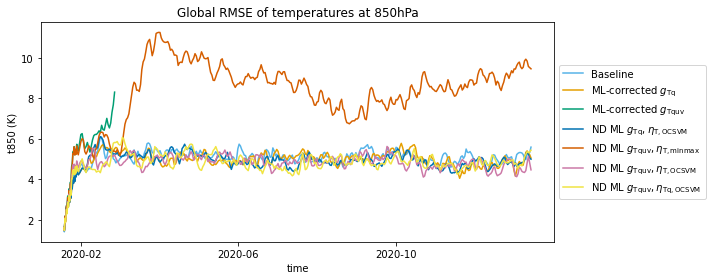

In [ ]:
# use xr plots to visualize time vs rmse temp850 
# plt.rcParams['text.usetex'] = True
plt.figure(figsize=(10, 4), tight_layout=True)
for name, label in table_run_names.items():
    diags_complete[name].tmp850_rms_global.plot(label=label)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel(r"t850 (K)")
plt.title(r"Global RMSE of temperatures at 850hPa")
plt.show()

## Figure {fig: temp-map-plots}

In [ ]:
map_plot_names = {
    "baseline": r"1 Baseline",
    "prognostic": r"3 ML-corrected $g_{\mathrm{Tquv}}$",
    "ocsvm-humidity-gamma-4_79-0": r"7 ND ML $g_{\mathrm{Tquv}}, \eta_{\mathrm{Tq, OCSVM}}$",
}

In [ ]:
common_coords = {"tile": range(6), "x": range(48), "y": range(48)}
grid = catalog["grid/c48"].read().assign_coords(common_coords)

In [ ]:
temp_biases = xr.concat(
    [diags_complete[name].tmp850_time_mean_bias.assign_coords(common_coords).to_dataset(name="ds") for name in map_plot_names],
    dim=pd.Index(map_plot_names.values(), name="run")
)

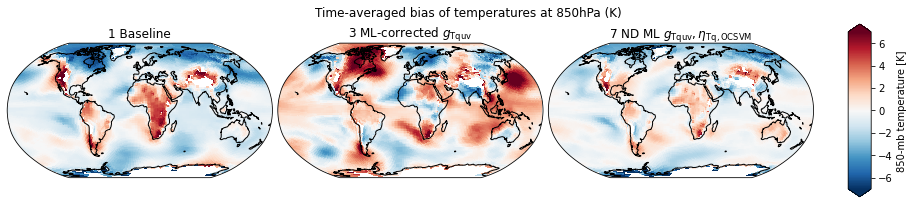

In [ ]:
fig, subplots, _, _, _  = fv3viz.plot_cube(
    temp_biases[["ds"]].merge(grid),   
    "ds",
    col="run",
    vmin=-7,
    vmax=7
)
for i, title in enumerate(map_plot_names.values()):
    subplots[0][i].set_title(title)
fig.set_size_inches(16, 3)
fig.suptitle("Time-averaged bias of temperatures at 850hPa (K)")
fig.show()


## AMS Abstract Figure

In [ ]:
ams_map_plot_names = {
    "baseline": r"Baseline",
    "prognostic-tq": r"ML without wind or novelty detection",
    "ocsvm-humidity-gamma-4_79-0": r"ML with wind and novelty detection",
}

In [ ]:
ams_temp_biases = xr.concat(
    [diags_complete[name].tmp850_time_mean_bias.assign_coords(common_coords).to_dataset(name="ds") for name in ams_map_plot_names],
    dim=pd.Index(ams_map_plot_names.values(), name="run")
)

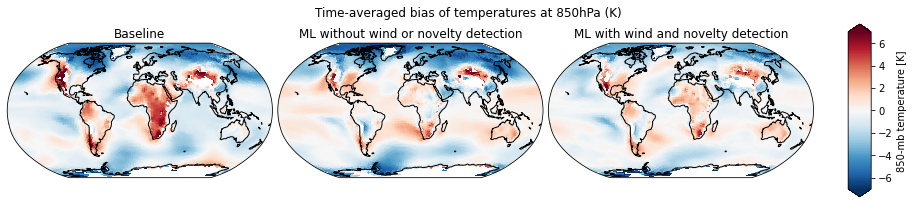

In [ ]:
fig, subplots, _, _, _  = fv3viz.plot_cube(
    ams_temp_biases[["ds"]].merge(grid),   
    "ds",
    col="run",
    vmin=-7,
    vmax=7
)
for i, title in enumerate(ams_map_plot_names.values()):
    subplots[0][i].set_title(title)
fig.set_size_inches(16, 3)
fig.suptitle("Time-averaged bias of temperatures at 850hPa (K)")
fig.show()

## Table {tab:metrics-thres}

In [ ]:
link_table_run_names = {
    "ocsvm-gamma-4_79-0": r"$\psi_{\mathrm{mask}}",
    "ocsvm-gamma-4_79-0-ramp-0.1": r"$\psi_{\mathrm{ramp}, 0.1}",
    "ocsvm-gamma-4_79-0-ramp-0.25": r"$\psi_{\mathrm{ramp}, 0.25}",
    "ocsvm-gamma-4_79-0-ramp-0.5": r"$\psi_{\mathrm{ramp}, 0.5}",
    "ocsvm-gamma-4_79-0-decay-0.25-0.005": r"$\psi_{\mathrm{decay}, 0.25, 0.005}",
    "ocsvm-gamma-4_79-0-decay-0.25-0.01": r"$\psi_{\mathrm{decay}, 0.25, 0.01}",
    "ocsvm-gamma-4_79-0-decay-0.25-0.02": r"$\psi_{\mathrm{decay}, 0.25, 0.02}",
}

In [ ]:
for name in link_table_run_names:
    for metric in table_metrics:
        print(f"{name} {table_metrics}: {metrics[name][metric]}")

ocsvm-gamma-4_79-0 ['rmse_of_time_mean/tmp850', 'rmse_of_time_mean/total_precip_to_surface', 'rmse_of_time_mean/pwat']: {'value': 1.5770646333694458, 'units': 'K'}
ocsvm-gamma-4_79-0 ['rmse_of_time_mean/tmp850', 'rmse_of_time_mean/total_precip_to_surface', 'rmse_of_time_mean/pwat']: {'value': 1.397950610395797, 'units': 'mm/day'}
ocsvm-gamma-4_79-0 ['rmse_of_time_mean/tmp850', 'rmse_of_time_mean/total_precip_to_surface', 'rmse_of_time_mean/pwat']: {'value': 2.656738042831421, 'units': 'kg/m**2'}
ocsvm-gamma-4_79-0-ramp-0.1 ['rmse_of_time_mean/tmp850', 'rmse_of_time_mean/total_precip_to_surface', 'rmse_of_time_mean/pwat']: {'value': 1.4913654327392578, 'units': 'K'}
ocsvm-gamma-4_79-0-ramp-0.1 ['rmse_of_time_mean/tmp850', 'rmse_of_time_mean/total_precip_to_surface', 'rmse_of_time_mean/pwat']: {'value': 1.3598054649985836, 'units': 'mm/day'}
ocsvm-gamma-4_79-0-ramp-0.1 ['rmse_of_time_mean/tmp850', 'rmse_of_time_mean/total_precip_to_surface', 'rmse_of_time_mean/pwat']: {'value': 2.7317073

## Figure {fig:smooth-nd-map}

In [ ]:
link_map_plot_names = {
    "ocsvm-gamma-4_79-0": r"$\psi_{\mathrm{mask}}$",
    "ocsvm-gamma-4_79-0-ramp-0.25": r"$\psi_{\mathrm{ramp}, 0.25}$",
    "ocsvm-gamma-4_79-0-decay-0.25-0.01": r"$\psi_{\mathrm{decay}, 0.25, 0.01}$",
}

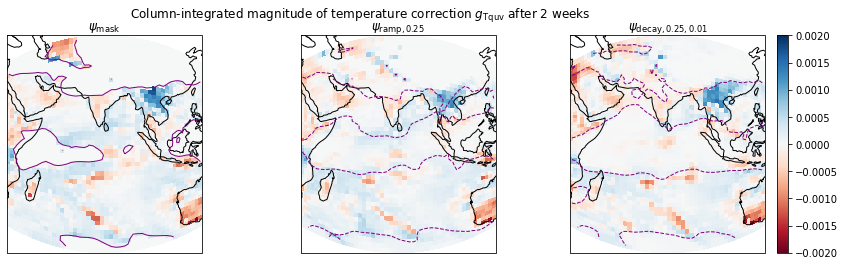

In [ ]:
# fig = plt.figure(figsize=(4, 16))
num_weeks = 2
time_freeze = 4 * 7 * num_weeks

link_ds = xr.concat(
    [diags_3d[name].dQ1.isel(time=time_freeze).sum("z").assign_coords(common_coords).to_dataset(name="correction") for name in link_map_plot_names],
    dim=pd.Index(link_map_plot_names.values(), name="run")
)
link_ds = link_ds.merge(grid)

score = xr.concat(
    [diags[name].centered_score.isel(time=time_freeze*2+1).assign_coords(common_coords).to_dataset(name="score") for name in link_map_plot_names],
    dim=pd.Index(link_map_plot_names.values(), name="run")
)
score = score.merge(grid)

cutoffs = [0, -0.25, -0.25]

tile = 1
fig = plt.figure()
for i, title in enumerate(link_map_plot_names.values()):
    ax = plt.subplot(1, 3, i+1, projection=ccrs.Mercator())
    lon = link_ds.lon.isel(tile=tile)
    im = ax.pcolormesh(lon, link_ds.lat.isel(tile=tile), link_ds.correction.isel(tile=tile, run=i), transform=ccrs.PlateCarree(), vmin=-0.002, vmax=0.002, cmap='RdBu')
    ax.contour(lon, score.lat.isel(tile=tile), score.score.isel(tile=tile, run=i), [cutoffs[i]], transform=ccrs.PlateCarree(), linewidths=1, colors="purple")
    # ax.contourf(lon, score.lat.isel(tile=tile), score.score.isel(tile=tile, run=i), [cutoffs[i], 1000000], transform=ccrs.PlateCarree(), colors="yellow", alpha=0.3)
    ax.set_title(title)
    ax.coastlines()
fig.subplots_adjust(right=0.95)
fig.colorbar(im)
fig.set_size_inches(14, 4)
fig.suptitle(r"Column-integrated magnitude of temperature correction $g_{\mathrm{Tquv}}$ after " + str(num_weeks) + r" weeks")
fig.show()


## Figure {fig:temp-explosion}

In [ ]:
max_time = 160
time_sl = slice("2020-01-19", "2020-03-30")
table_run_names = {
    "prognostic": r"ML-corrected $g_{\mathrm{Tquv}}$",
    "minmax-0": r"ND ML $g_{\mathrm{Tquv}}, \eta_{\mathrm{T, minmax}}$",
    "ocsvm-gamma-1_4_79-0": r"ND ML $g_{\mathrm{Tquv}}, \eta_{\mathrm{T, OCSVM}}, \gamma=\frac{1}{4 \cdot 79}$",
    "ocsvm-gamma-4_79-0": r"ND ML $g_{\mathrm{Tquv}}, \eta_{\mathrm{T, OCSVM}}, \gamma=\frac{4}{79}$",
}


In [ ]:
explosion_ds = xr.concat(
    [diags_complete[name].tmp200_zonal_mean_bias for name in table_run_names],
    dim=pd.Index(table_run_names.values(), name="run"),
)

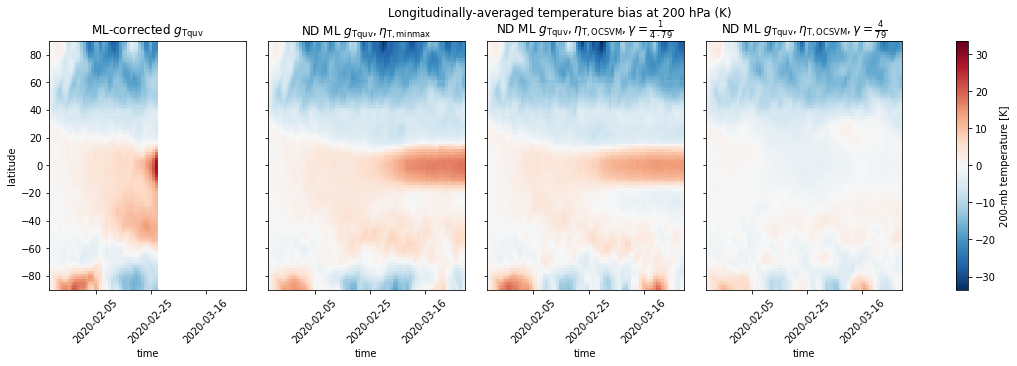

In [ ]:
# plt.setp(ax.xaxis.get_majorticklabels(), rotation=50)
im = explosion_ds.sel(time=time_sl).plot(col = "run")
# plt.draw()
for i, title in enumerate(table_run_names.values()):
    im.axes[0][i].set_title(title)
    im.axes[0][i].tick_params(axis='x', labelrotation = 45)
im.fig.set_size_inches(16, 5)
# plt.xticks(rotation = 45)
im.fig.suptitle("Longitudinally-averaged temperature bias at 200 hPa (K)")
plt.show()

## Figure {fig:temp-explosion-novelty}

In [ ]:
max_time = 160
time_sl = slice("2020-01-19", "2020-03-30")


In [ ]:
explosion_novelty_ds = xr.concat(
    [diags_complete[name].is_novelty_zonal_mean_value if name != "prognostic"
    else 0 * diags_complete[name].tmp200_zonal_mean_bias
    for name in table_run_names],
    dim=pd.Index(table_run_names.values(), name="run"),
)

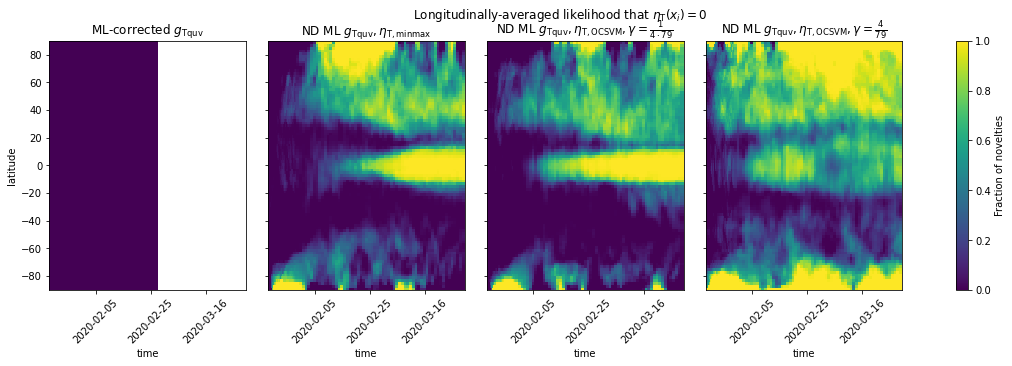

In [ ]:
im = explosion_novelty_ds.sel(time=time_sl).plot(col = "run")
for i, title in enumerate(table_run_names.values()):
    im.axes[0][i].set_title(title)
    im.axes[0][i].tick_params(axis='x', labelrotation = 45)
im.fig.set_size_inches(16, 5)
im.fig.suptitle(r"Longitudinally-averaged likelihood that $\eta_{\mathrm{T}}(x_i) = 0$")
im.cbar.set_label("Fraction of novelties")
plt.show()

## Figure {fig:temp-explosion-map}

In [ ]:
time_sl_before_crash = slice("2020-01-19", "2020-02-26")

explosion_ds_map = xr.concat(
    [(atmos[name].TMP200 - validation.TMP200).sel(time=time_sl_before_crash).mean("time").rename({"grid_xt": "x", "grid_yt": "y"}).assign_coords(common_coords) for name in table_run_names],
    dim=pd.Index(table_run_names.values(), name="run"),
)

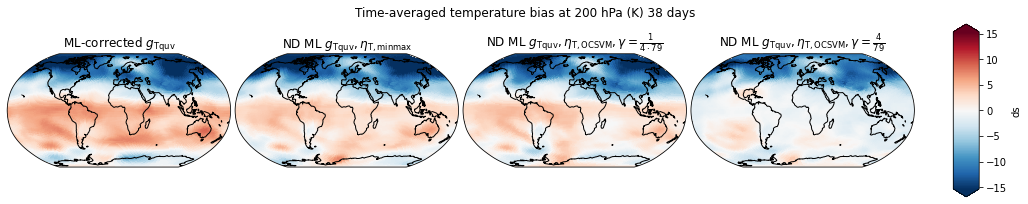

In [ ]:
fig, subplots, _, _, _  = fv3viz.plot_cube(
    explosion_ds_map.to_dataset(name="ds").merge(grid),   
    "ds",
    col="run",
)
for i, title in enumerate(table_run_names.values()):
    subplots[0][i].set_title(title)
fig.set_size_inches(18, 3)
fig.suptitle("Time-averaged temperature bias at 200 hPa (K) 38 days")
fig.show()


In [ ]:
table_run_novelty_names = {
    "minmax-0": r"ND ML $g_{\mathrm{Tquv}}, \eta_{\mathrm{T, minmax}}$",
    "ocsvm-gamma-1_4_79-0": r"ND ML $g_{\mathrm{Tquv}}, \eta_{\mathrm{T, OCSVM}}, \gamma=\frac{1}{4 \cdot 79}$",
    "ocsvm-gamma-4_79-0": r"ND ML $g_{\mathrm{Tquv}}, \eta_{\mathrm{T, OCSVM}}, \gamma=\frac{4}{79}$",
}

explosion_ds_map_all_time = xr.concat(
    [(atmos[name].TMP200 - validation.TMP200).mean("time").rename({"grid_xt": "x", "grid_yt": "y"}).assign_coords(common_coords) for name in table_run_novelty_names],
    dim=pd.Index(table_run_novelty_names.values(), name="run"),
)

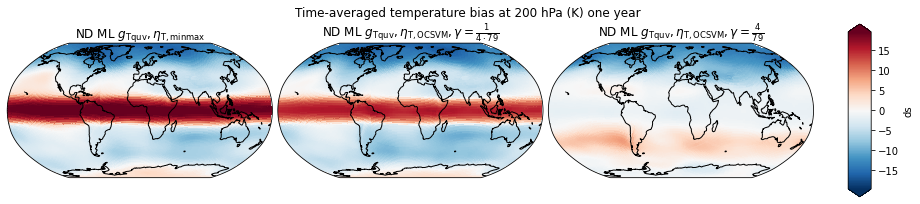

In [ ]:
fig, subplots, _, _, _  = fv3viz.plot_cube(
    explosion_ds_map_all_time.to_dataset(name="ds").merge(grid),   
    "ds",
    col="run",
)
for i, title in enumerate(table_run_novelty_names.values()):
    subplots[0][i].set_title(title)
fig.set_size_inches(16, 3)
fig.suptitle("Time-averaged temperature bias at 200 hPa (K) one year")
fig.show()


## Figure {fig:params}

In [ ]:
minmax_names = get_names_alg("minmax")
minmax_cutoffs = [runs[i]["cutoff"] for i in runs if i in minmax_names]
ocsvm_large_names = get_names_alg("ocsvm", gamma=4/79)
ocsvm_large_cutoffs = [runs[i]["cutoff"] for i in runs if i in ocsvm_large_names]
ocsvm_default_names = get_names_alg("ocsvm", gamma=1/79)
ocsvm_default_cutoffs = [runs[i]["cutoff"] for i in runs if i in ocsvm_default_names]
ocsvm_small_names = get_names_alg("ocsvm", gamma=1/4/79)
ocsvm_small_cutoffs = [runs[i]["cutoff"] for i in runs if i in ocsvm_small_names]
ocsvm_names = {
    4/79: ocsvm_large_names,
    1/79: ocsvm_default_names,
    1/4/79: ocsvm_small_names
}
ocsvm_cutoffs = {
    4/79: ocsvm_large_cutoffs,
    1/79: ocsvm_default_cutoffs,
    1/4/79: ocsvm_small_cutoffs
}
minmax_names_bp = get_names_alg("minmax", include_bp=True)
ocsvm_large_names_bp = get_names_alg("ocsvm", gamma=4/79, include_bp=True)
ocsvm_default_names_bp = get_names_alg("ocsvm", gamma=1/79, include_bp=True)
ocsvm_small_names_bp = get_names_alg("ocsvm", gamma=1/4/79, include_bp=True)

gamma_strs = {
    4/79: r"$\gamma = \frac{4}{79}$",
    1/79: r"$\gamma = \frac{1}{79}$",
    1/4/79: r"$\gamma = \frac{1}{316}$",
}

metric_strs = ["rmse_of_time_mean/tmp850", "rmse_of_time_mean/total_precip_to_surface", "rmse_of_time_mean/pwat"]
metric_names = ["RMSE T (K)", "RMSE SP (mm/day)", "PWAT (kg/$\mathrm{m}^2)$"]


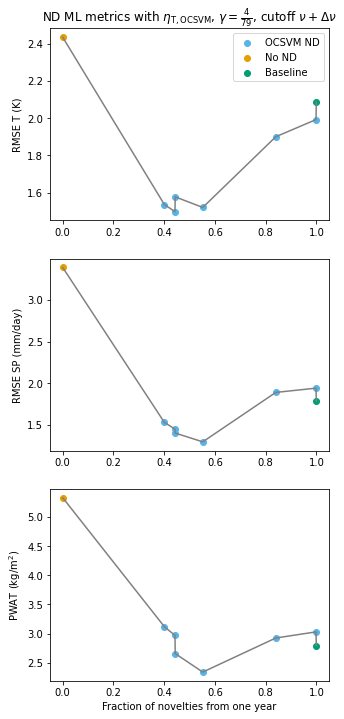

In [ ]:

fig = plt.figure(figsize=(5, 12))
# fig.suptitle(f"{metric_str} for {names[i]}")

for i, metric_str in enumerate(metric_strs):

    ax = plt.subplot(3, 1, i+1)

    metric = [metrics[j][metric_str]["value"] for j in ocsvm_large_names]
    metric_bp = [metrics[j][metric_str]["value"] for j in ocsvm_large_names_bp]
    novelty_fracs, metric_bp_online = zip(*sorted(zip([novelty_fractions[name] for name in ocsvm_large_names_bp], metric_bp)))
    ax.plot(novelty_fracs, metric_bp_online, c="gray")
    ax.scatter([novelty_fractions[name] for name in ocsvm_large_names], metric, label="OCSVM ND")
    ax.scatter([novelty_fractions["prognostic"]], [metrics["prognostic"][metric_str]["value"]], label="No ND")
    ax.scatter([novelty_fractions["baseline"]], [metrics["baseline"][metric_str]["value"]], label="Baseline")
    ax.set_ylabel(metric_names[i])
    if i == 0:
            ax.set_title(r"ND ML metrics with $\eta_{\mathrm{T, OCSVM}}$, " +  gamma_strs[4/79] + r", cutoff $\nu + \Delta \nu$")
            plt.legend()
    if i == 2:
        ax.set_xlabel("Fraction of novelties from one year")

plt.show()

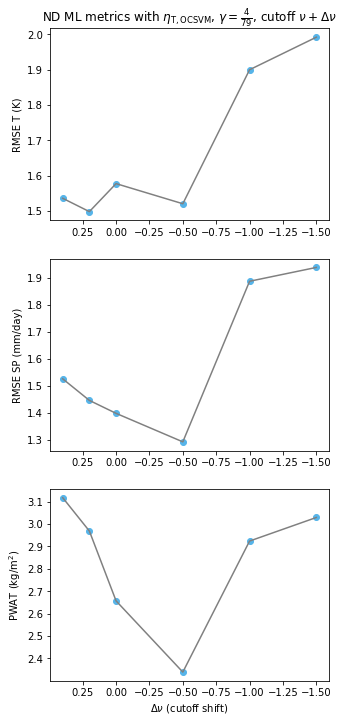

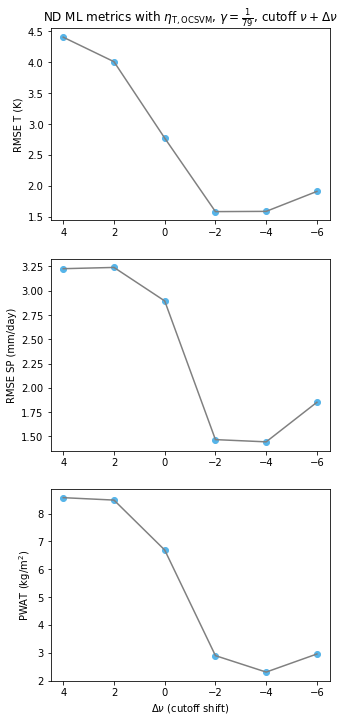

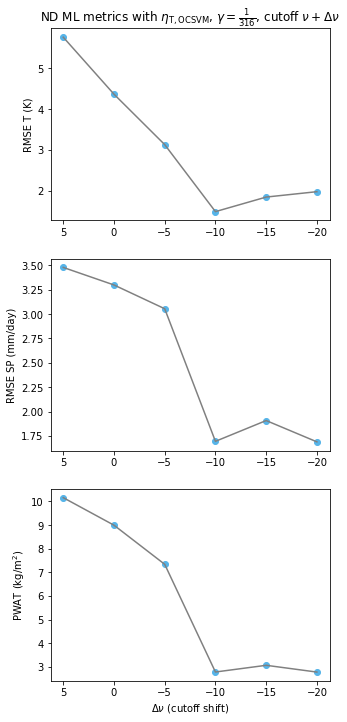

In [ ]:

for gamma in [4/79, 1/79, 1/4/79]:

    fig = plt.figure(figsize=(5, 12))

    for i, metric_str in enumerate(metric_strs):
        ax = plt.subplot(3, 1, i+1)

        metric = [metrics[j][metric_str]["value"] for j in ocsvm_names[gamma]]
        ax.scatter(ocsvm_cutoffs[gamma], metric)
        ax.plot(ocsvm_cutoffs[gamma], metric, c="gray")
        ax.invert_xaxis()
        ax.set_ylabel(metric_names[i])
        if i == 0:
            ax.set_title(r"ND ML metrics with $\eta_{\mathrm{T, OCSVM}}$, " +  gamma_strs[gamma] + r", cutoff $\nu + \Delta \nu$")
        if i == 2:
            ax.set_xlabel(r"$\Delta \nu$ (cutoff shift)")

    # plt.suptitle(r"Metrics for Prog. ND with $\eta_{\mathrm{t, OCSVM}}$, cutoff $\nu + \Delta \nu$")
    plt.show()

## Columns

In [ ]:
def map_plot(df):
    common_coords = {"tile": range(6), "x": range(48), "y": range(48)}
    grid = catalog["grid/c48"].read().assign_coords(common_coords)
    fv3viz.plot_cube(
        df.to_dataset(name="ds").merge(grid),   
        "ds")

In [42]:
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

No handles with labels found to put in legend.


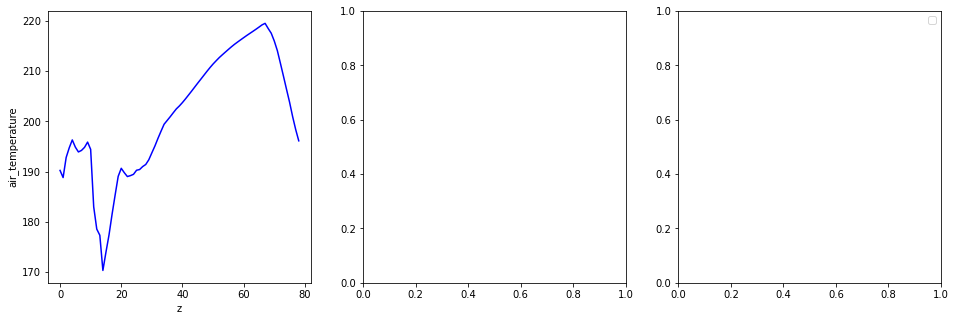

In [ ]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(16, 5)
colors = ["blue", "red"]
state_baseline = states["baseline"]
state_baseline.air_temperature.min(("time", "x", "y", "tile")).plot(ax=axes[0], color=colors[0], label="min")
# state_baseline.air_temperature.max("time").plot(ax=axes[0], color=colors[1], label="max")
# state_baseline.specific_humidity.min("time").plot(ax=axes[1], color=colors[0], label="min")
# state_baseline.specific_humidity.max("time").plot(ax=axes[1], color=colors[1], label="max")
# state_baseline.specific_humidity.min("time").plot(ax=axes[2], color=colors[0], label="min")
# state_baseline.specific_humidity.max("time").plot(ax=axes[2], color=colors[1], label="max")
plt.legend()
plt.show()


In [32]:
state_baseline = states["baseline"]

bl_temp_min = state_baseline.air_temperature.min(("time", "x", "y", "tile")).load()
bl_temp_max = state_baseline.air_temperature.max(("time", "x", "y", "tile")).load()
bl_hum_min = state_baseline.specific_humidity.min(("time", "x", "y", "tile")).load()
bl_hum_max = state_baseline.specific_humidity.max(("time", "x", "y", "tile")).load()


In [16]:
state_humidity = states["ocsvm-humidity-gamma-4_79-0"]
diags_humidity = diags["ocsvm-humidity-gamma-4_79-0"]

In [48]:
state_humidity.time

<xarray.DataArray 'time' (time: 1440)>
array([cftime.DatetimeJulian(2020, 1, 19, 6, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2020, 1, 19, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2020, 1, 19, 18, 0, 0, 0, has_year_zero=False),
       ...,
       cftime.DatetimeJulian(2021, 1, 12, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2021, 1, 12, 18, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2021, 1, 13, 0, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * time     (time) object 2020-01-19 06:00:00 ... 2021-01-13 00:00:00

In [49]:
diags_humidity.time

<xarray.DataArray 'time' (time: 2880)>
array([cftime.DatetimeJulian(2020, 1, 19, 3, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2020, 1, 19, 6, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2020, 1, 19, 9, 0, 0, 0, has_year_zero=False),
       ...,
       cftime.DatetimeJulian(2021, 1, 12, 18, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2021, 1, 12, 21, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2021, 1, 13, 0, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * time     (time) object 2020-01-19 03:00:00 ... 2021-01-13 00:00:00

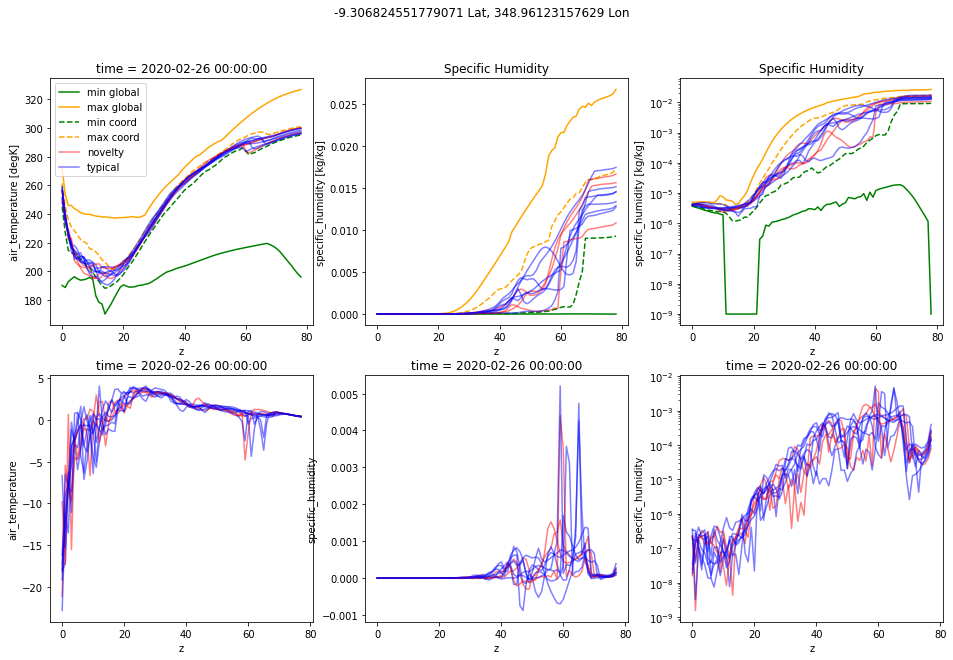

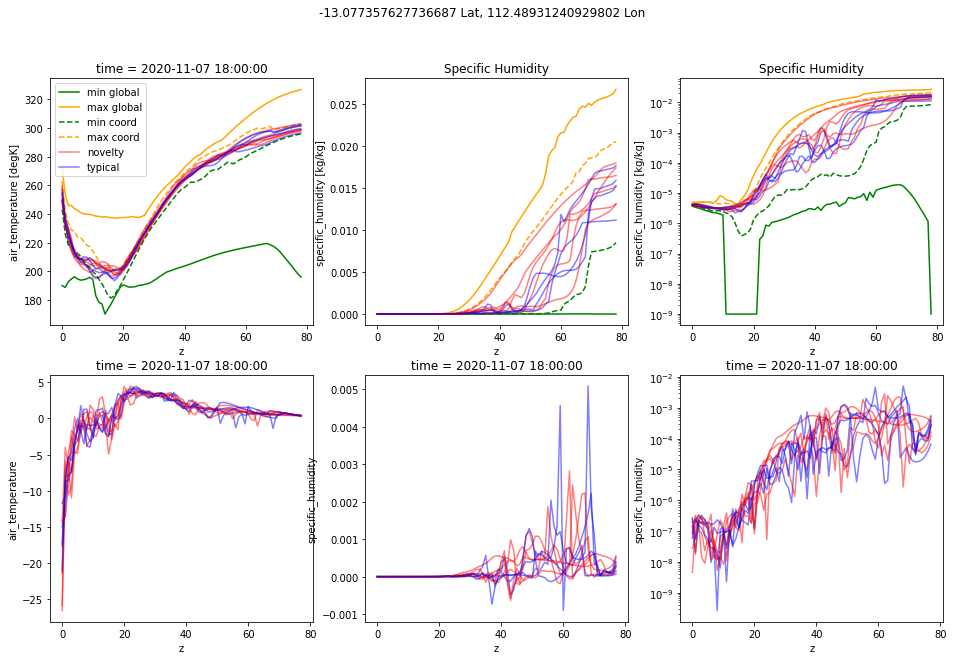

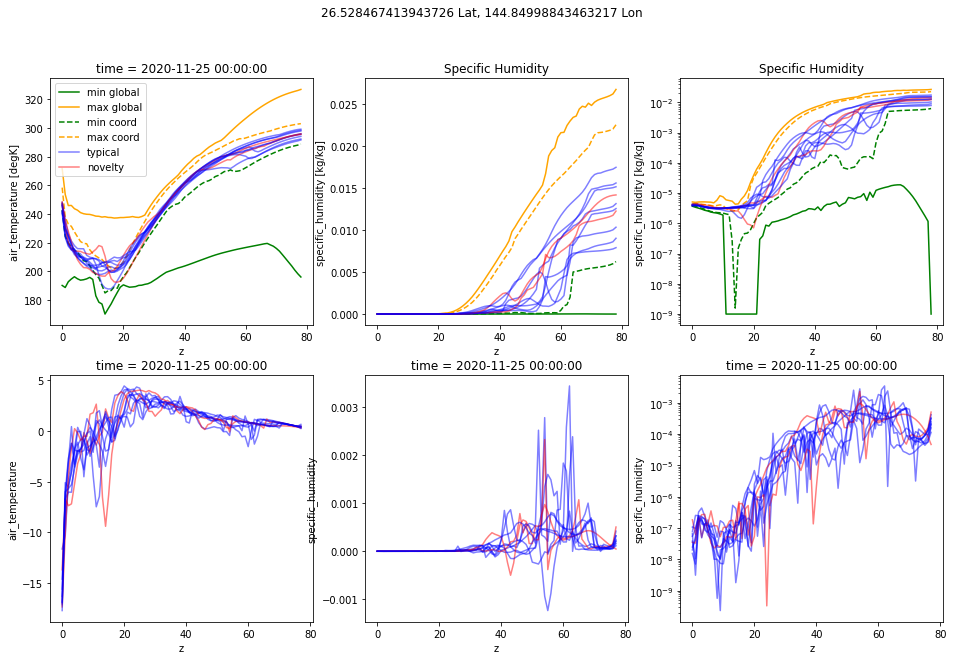

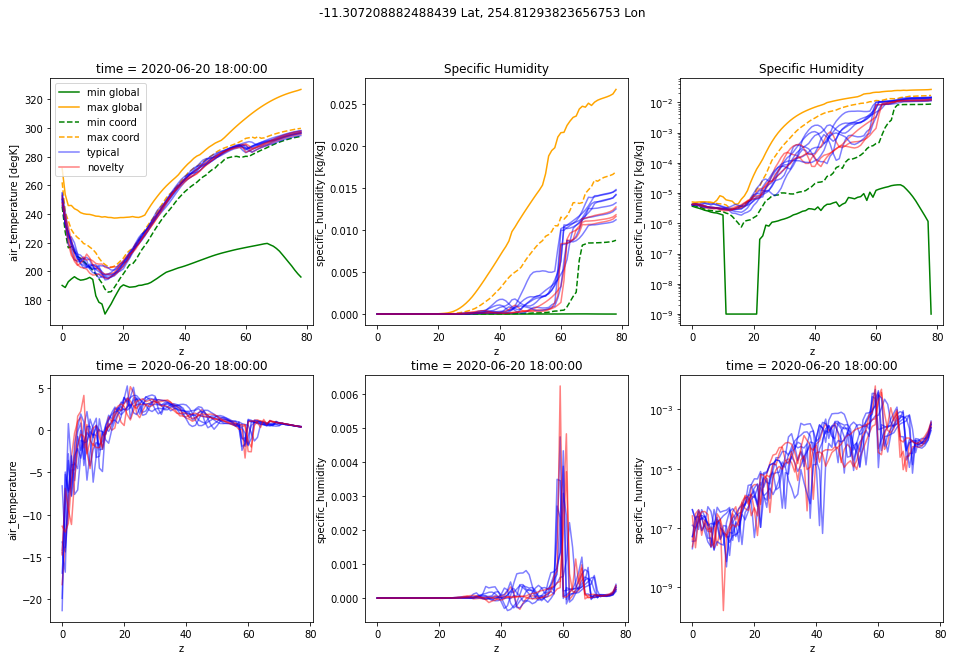

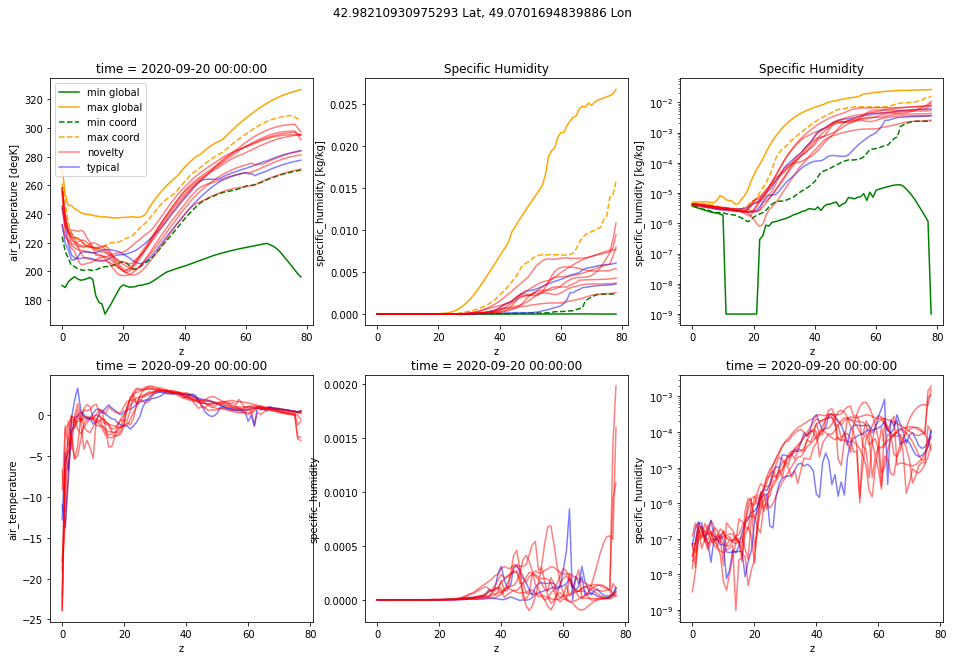

KeyboardInterrupt: 

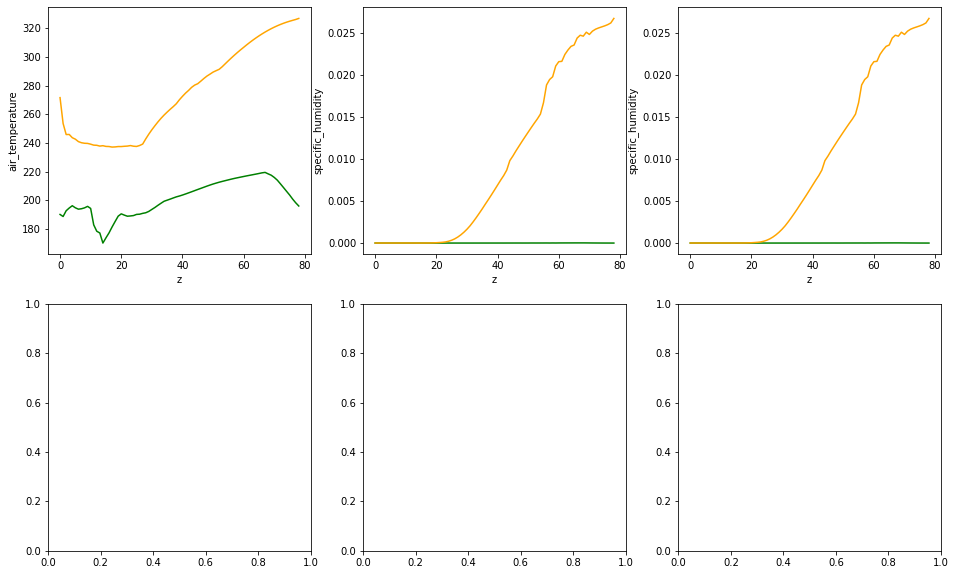

In [43]:
state_humidity = states["ocsvm-humidity-gamma-4_79-0"]
diags_humidity = diags["ocsvm-humidity-gamma-4_79-0"]
for _ in range(20):
    rand_times = np.random.randint(0, state_humidity.time.size, 20)
    rand_tile = np.random.randint(0, 6, 1)
    rand_x = np.random.randint(0, 48, 1)
    rand_y = np.random.randint(0, 48, 1)
    colors = ["blue", "red", "green", "orange"]
    labels = ["typical", "novelty"]
    fig, axes = plt.subplots(2, 3)
    fig.set_size_inches(16, 10)
    lat = state_humidity.latitude.isel(time=rand_times[0], x=rand_x, y=rand_y, tile=rand_tile).values[0][0][0]
    lon = state_humidity.longitude.isel(time=rand_times[0], x=rand_x, y=rand_y, tile=rand_tile).values[0][0][0]
    # state_baseline.air_temperature.min(("time", "x", "y", "tile")).plot(ax=axes[0], color=colors[2], label="min global")
    # state_baseline.air_temperature.max(("time", "x", "y", "tile")).plot(ax=axes[0], color=colors[3], label="max global")
    # state_baseline.specific_humidity.min(("time", "x", "y", "tile")).plot(ax=axes[1], color=colors[2], label="min global")
    # state_baseline.specific_humidity.max(("time", "x", "y", "tile")).plot(ax=axes[1], color=colors[3], label="max global")
    # state_baseline.specific_humidity.min(("time", "x", "y", "tile")).plot(ax=axes[2], color=colors[2], label="min global")
    # state_baseline.specific_humidity.max(("time", "x", "y", "tile")).plot(ax=axes[2], color=colors[3], label="max global")
    bl_temp_min.plot(ax=axes[0][0], color=colors[2], label="min global")
    bl_temp_max.plot(ax=axes[0][0], color=colors[3], label="max global")
    bl_hum_min.plot(ax=axes[0][1], color=colors[2], label="min global")
    bl_hum_max.plot(ax=axes[0][1], color=colors[3], label="max global")
    bl_hum_min.plot(ax=axes[0][2], color=colors[2], label="min global")
    bl_hum_max.plot(ax=axes[0][2], color=colors[3], label="max global")
    bl_temps = state_baseline.air_temperature.isel(x=rand_x, y=rand_y, tile=rand_tile).load()
    bl_hum = state_baseline.specific_humidity.isel(x=rand_x, y=rand_y, tile=rand_tile).load()
    # state_baseline.air_temperature.isel(x=rand_x, y=rand_y, tile=rand_tile).min("time").plot(ax=axes[0], color=colors[2], label="min coord", linestyle="dashed")
    # state_baseline.air_temperature.isel(x=rand_x, y=rand_y, tile=rand_tile).max("time").plot(ax=axes[0], color=colors[3], label="max coord", linestyle="dashed")
    # state_baseline.specific_humidity.isel(x=rand_x, y=rand_y, tile=rand_tile).min("time").plot(ax=axes[1], color=colors[2], label="min coord", linestyle="dashed")
    # state_baseline.specific_humidity.isel(x=rand_x, y=rand_y, tile=rand_tile).max("time").plot(ax=axes[1], color=colors[3], label="max coord", linestyle="dashed")
    # state_baseline.specific_humidity.isel(x=rand_x, y=rand_y, tile=rand_tile).min("time").plot(ax=axes[2], color=colors[2], label="min coord", linestyle="dashed")
    # state_baseline.specific_humidity.isel(x=rand_x, y=rand_y, tile=rand_tile).max("time").plot(ax=axes[2], color=colors[3], label="max coord", linestyle="dashed")
    bl_temps.min("time").plot(ax=axes[0][0], color=colors[2], label="min coord", linestyle="dashed")
    bl_temps.max("time").plot(ax=axes[0][0], color=colors[3], label="max coord", linestyle="dashed")
    bl_hum.min("time").plot(ax=axes[0][1], color=colors[2], label="min coord", linestyle="dashed")
    bl_hum.max("time").plot(ax=axes[0][1], color=colors[3], label="max coord", linestyle="dashed")
    bl_hum.min("time").plot(ax=axes[0][2], color=colors[2], label="min coord", linestyle="dashed")
    bl_hum.max("time").plot(ax=axes[0][2], color=colors[3], label="max coord", linestyle="dashed")

    for i in range(10):
        is_novelty = int(diags_humidity.is_novelty.isel(time=rand_times[i]*2+1, x=rand_x, y=rand_y, tile=rand_tile).values[0][0][0])
        nd_temps = state_humidity.air_temperature.isel(time=rand_times[i], x=rand_x, y=rand_y, tile=rand_tile).load()
        nd_hums = state_humidity.specific_humidity.isel(time=rand_times[i], x=rand_x, y=rand_y, tile=rand_tile).load()
        nd_temps.plot(ax=axes[0][0], color=colors[is_novelty], alpha=0.5, label=labels[is_novelty])
        nd_hums.plot(ax=axes[0][1], color=colors[is_novelty], alpha=0.5, label=labels[is_novelty])
        nd_hums.plot(yscale="log", ax=axes[0][2], color=colors[is_novelty], alpha=0.5, label=labels[is_novelty])
        nd_temps.diff("z").plot(ax=axes[1][0], color=colors[is_novelty], alpha=0.5, label=labels[is_novelty])
        nd_hums.diff("z").plot(ax=axes[1][1], color=colors[is_novelty], alpha=0.5, label=labels[is_novelty])
        xr.ufuncs.fabs(nd_hums.diff("z")).plot(yscale="log", ax=axes[1][2], color=colors[is_novelty], alpha=0.5, label=labels[is_novelty])

        # state_humidity.northward_wind.isel(time=rand_times[i], x=rand_x, y=rand_y, tile=rand_tile).plot(ax=axes[2], color=colors[is_novelty], alpha=0.5, label=labels[is_novelty])
        # state_humidity.eastward_wind.isel(time=rand_times[i], x=rand_x, y=rand_y, tile=rand_tile).plot(ax=axes[3], color=colors[is_novelty], alpha=0.5, label=labels[is_novelty])
    legend_without_duplicate_labels(axes[0][0])
    axes[0][1].set_title("Temperature")
    axes[0][1].set_title("Specific Humidity")
    axes[0][2].set_title("Specific Humidity")
    # axes[2].set_title("Northward Wind")
    # axes[3].set_title("Eastward Wind")
    fig.suptitle(f"{lat * 180 / math.pi} Lat, {lon * 180 / math.pi} Lon")
    # plt.legend()
    # state_humidity.air_temperature.isel(time=np.random.randint(0, state_humidity.time.size, 1), z = -1).mean("time")
    # map_plot(state_humidity.air_temperature.isel(time=np.random.randint(0, state_humidity.time.size, 1), z = -1).mean("time"))
    plt.show()

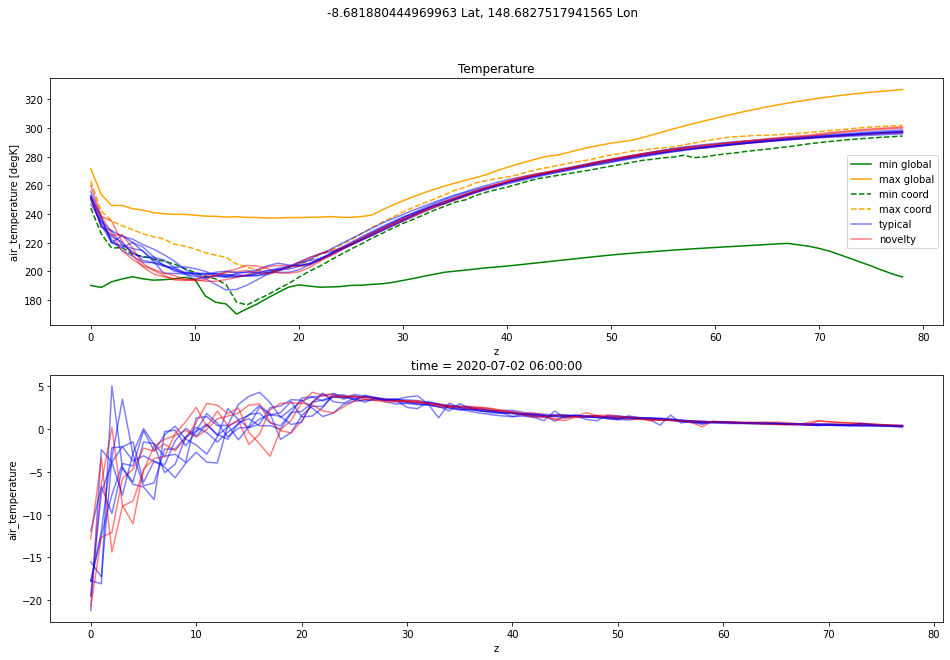

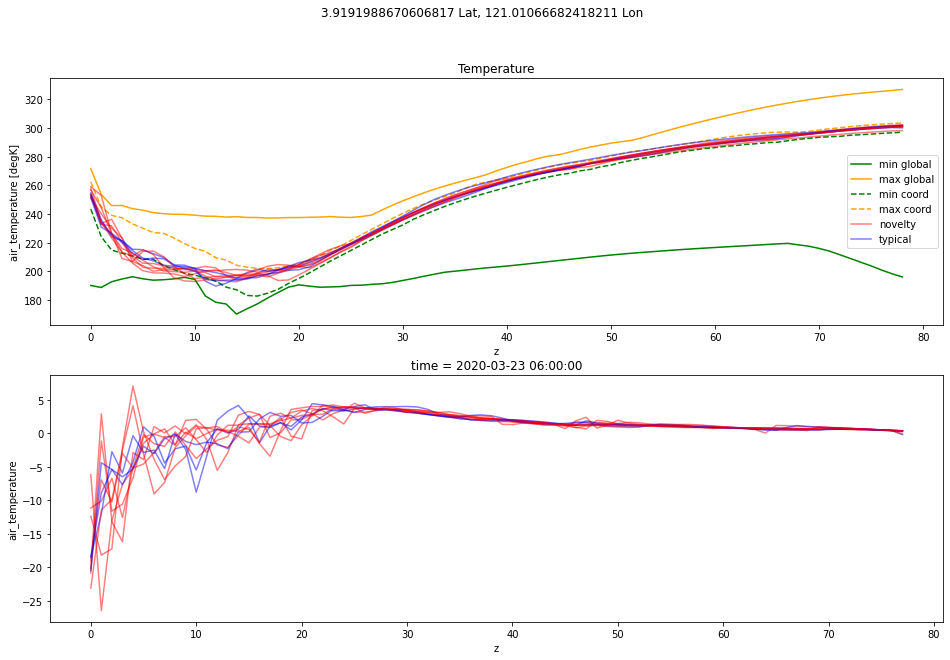

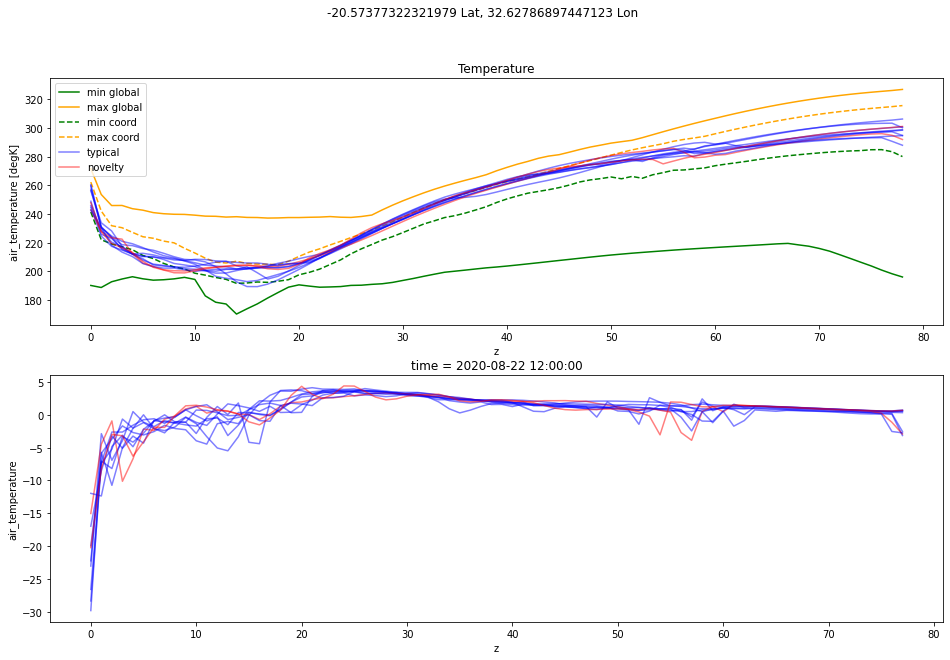

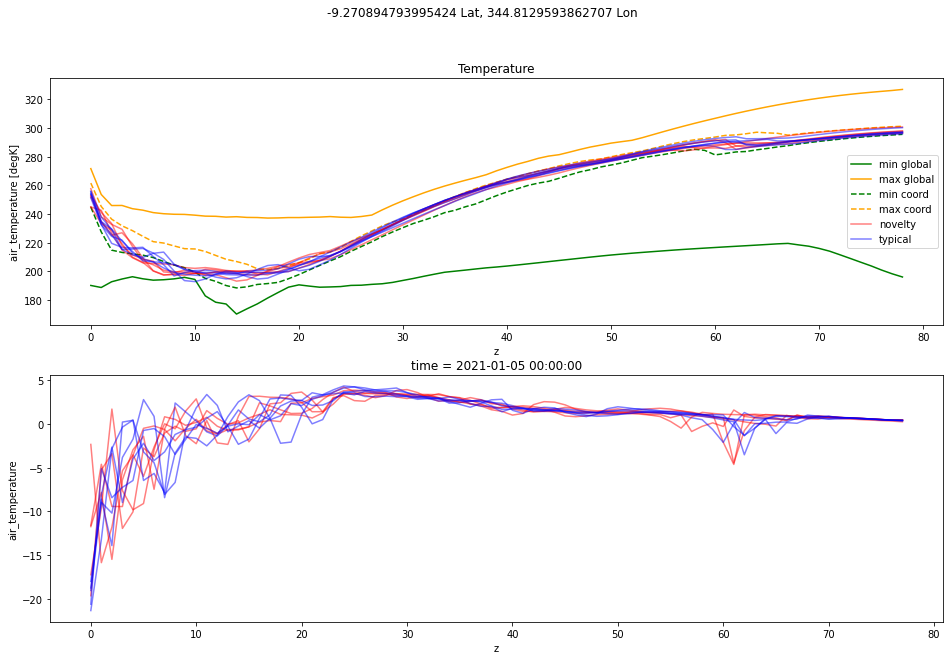

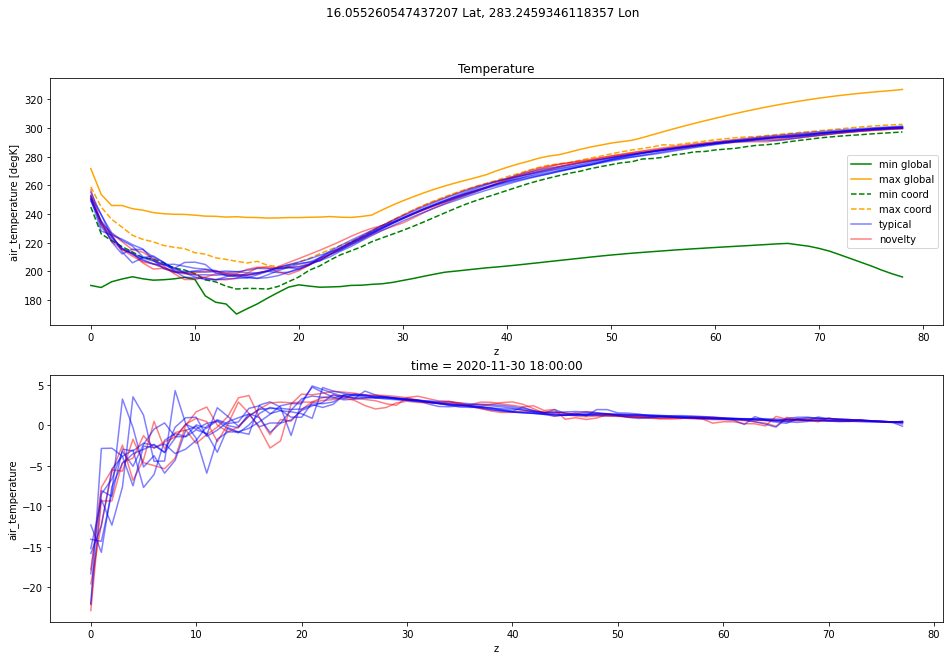

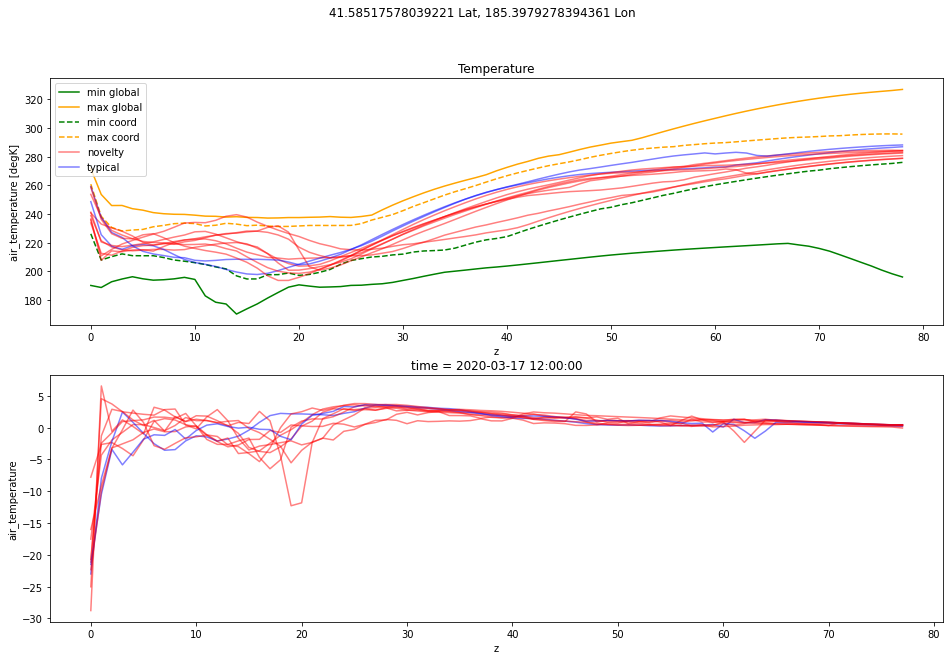

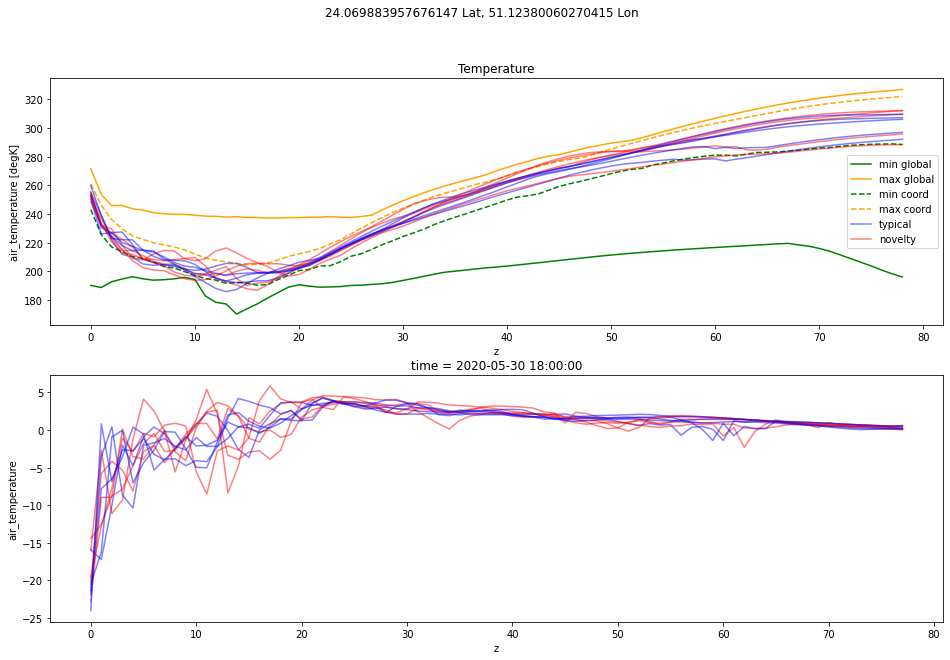

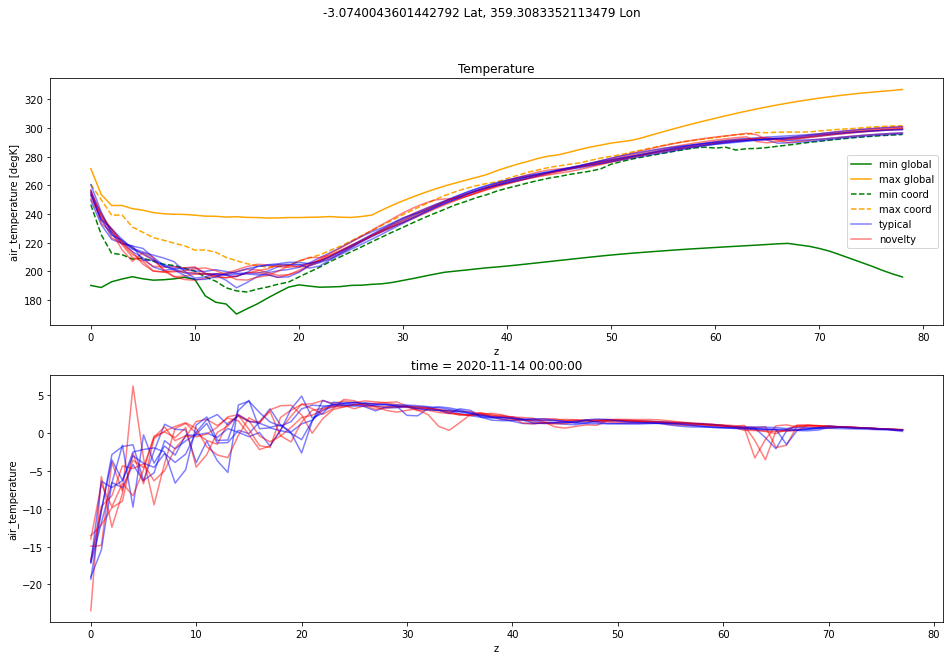

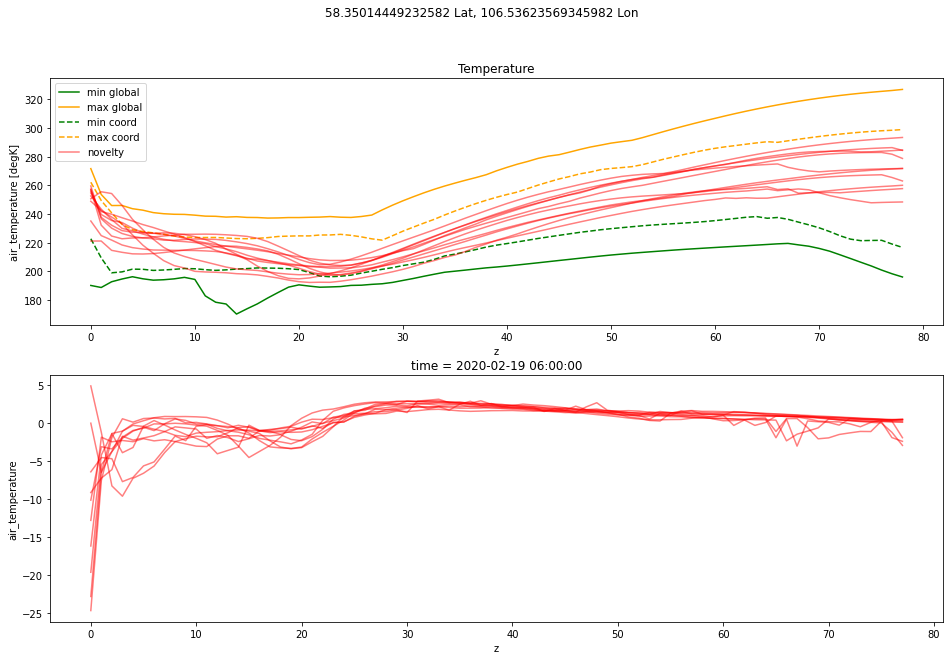

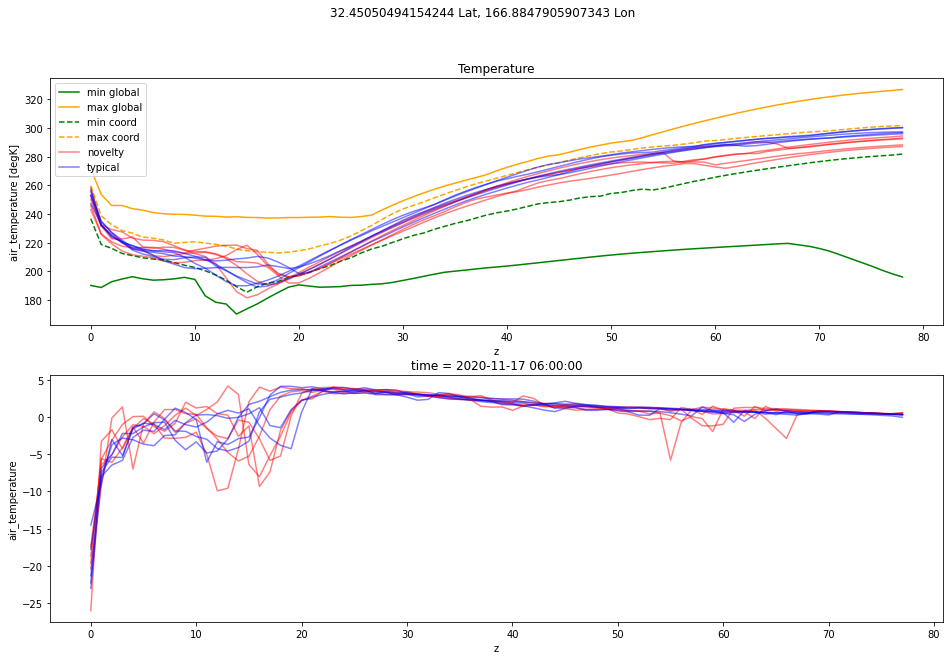

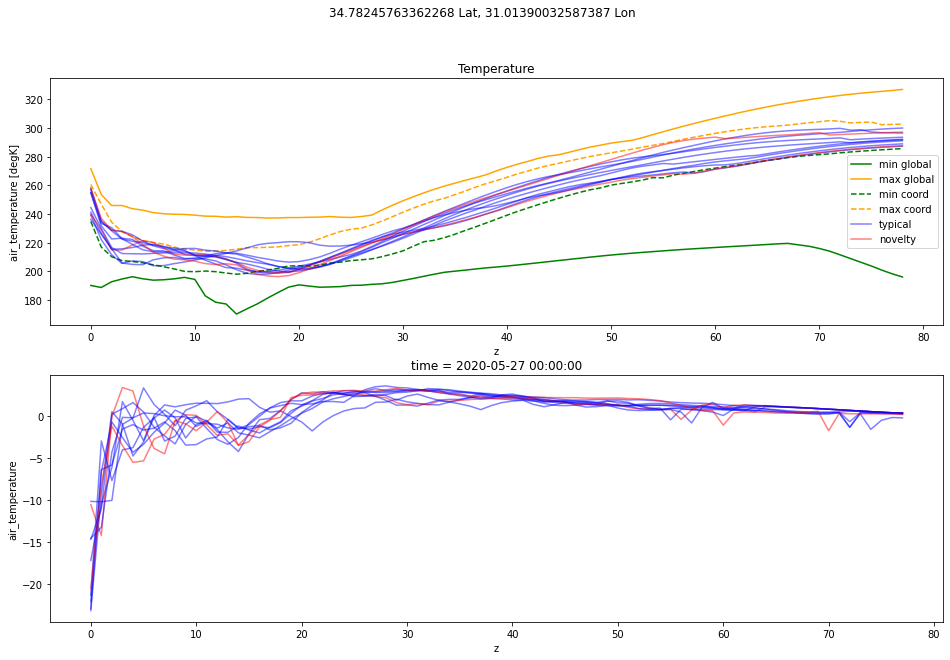

KeyboardInterrupt: 

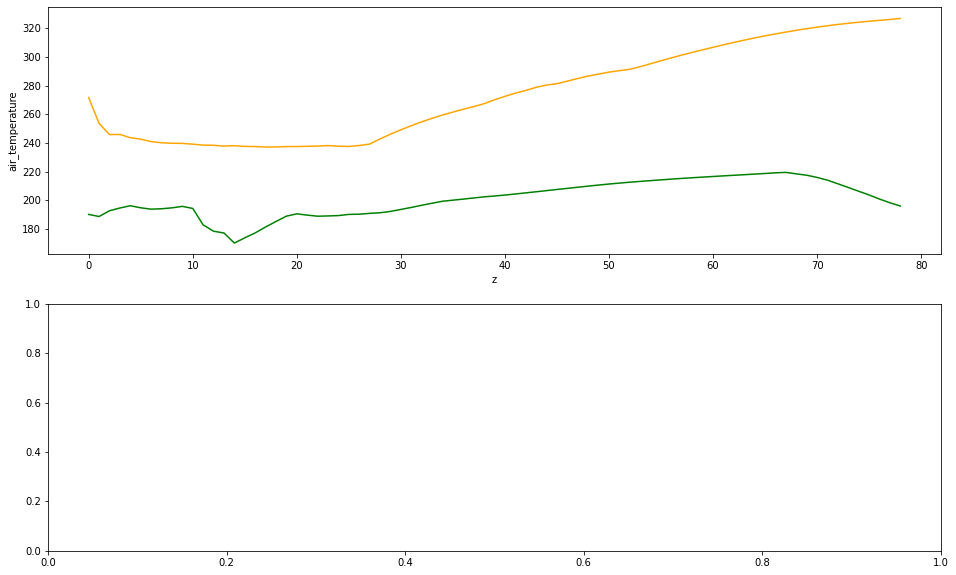

In [50]:
state_temp = states["ocsvm-gamma-4_79-0"]
diags_temp = diags["ocsvm-gamma-4_79-0"]
for _ in range(20):
    rand_times = np.random.randint(0, state_temp.time.size, 20)
    rand_tile = np.random.randint(0, 6, 1)
    rand_x = np.random.randint(0, 48, 1)
    rand_y = np.random.randint(0, 48, 1)
    colors = ["blue", "red", "green", "orange"]
    labels = ["typical", "novelty"]
    fig, axes = plt.subplots(2, 1)
    fig.set_size_inches(16, 10)
    lat = state_temp.latitude.isel(time=rand_times[0], x=rand_x, y=rand_y, tile=rand_tile).values[0][0][0]
    lon = state_temp.longitude.isel(time=rand_times[0], x=rand_x, y=rand_y, tile=rand_tile).values[0][0][0]
    bl_temp_min.plot(ax=axes[0], color=colors[2], label="min global")
    bl_temp_max.plot(ax=axes[0], color=colors[3], label="max global")
    bl_temps = state_baseline.air_temperature.isel(x=rand_x, y=rand_y, tile=rand_tile).load()
    bl_temps.min("time").plot(ax=axes[0], color=colors[2], label="min coord", linestyle="dashed")
    bl_temps.max("time").plot(ax=axes[0], color=colors[3], label="max coord", linestyle="dashed")

    for i in range(10):
        is_novelty = int(diags_temp.is_novelty.isel(time=rand_times[i]*2+1, x=rand_x, y=rand_y, tile=rand_tile).values[0][0][0])
        nd_temps = state_temp.air_temperature.isel(time=rand_times[i], x=rand_x, y=rand_y, tile=rand_tile).load()
        nd_temps.plot(ax=axes[0], color=colors[is_novelty], alpha=0.5, label=labels[is_novelty])
        nd_temps.diff("z").plot(ax=axes[1], color=colors[is_novelty], alpha=0.5, label=labels[is_novelty])
    legend_without_duplicate_labels(axes[0])
    axes[0].set_title("Temperature")
    fig.suptitle(f"{lat * 180 / math.pi} Lat, {lon * 180 / math.pi} Lon")
    plt.show()

In [36]:
rand_times[0]

33

In [37]:
state_humidity.time[rand_times[0]]

<xarray.DataArray 'time' ()>
array(cftime.DatetimeJulian(2020, 1, 27, 12, 0, 0, 0, has_year_zero=False),
      dtype=object)
Coordinates:
    time     object 2020-01-27 12:00:00

In [40]:
diags_humidity.time[rand_times[0]*2+1]

<xarray.DataArray 'time' ()>
array(cftime.DatetimeJulian(2020, 1, 27, 12, 0, 0, 0, has_year_zero=False),
      dtype=object)
Coordinates:
    time     object 2020-01-27 12:00:00

In [47]:
nd_temps.isel()

<xarray.DataArray 'air_temperature' (tile: 1, z: 79, y: 1, x: 1)>
array([[[[248.75237805]],

        [[222.81947872]],

        [[220.32574237]],

        [[216.04529921]],

        [[210.1511505 ]],

        [[208.0218553 ]],

        [[207.68504729]],

        [[206.39405982]],

        [[205.69295901]],

        [[206.04991239]],

...

        [[294.43851102]],

        [[295.33424034]],

        [[296.1599259 ]],

        [[296.91473132]],

        [[297.5985819 ]],

        [[298.21052834]],

        [[298.75075127]],

        [[299.22030849]],

        [[299.62416417]],

        [[299.99268605]]]])
Coordinates:
    time     object 2020-10-09 00:00:00
Dimensions without coordinates: tile, z, y, x
Attributes:
    units:    degK

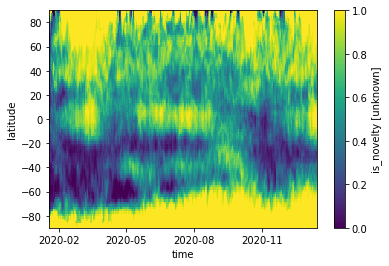

In [23]:
diags_complete["ocsvm-humidity-gamma-4_79-0"].is_novelty_zonal_mean_value.plot()

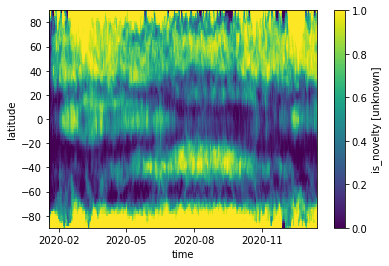

In [24]:
diags_complete["ocsvm-gamma-4_79-0"].is_novelty_zonal_mean_value.plot()

In [66]:
diags_humidity

<xarray.Dataset>
Dimensions:                                 (time: 2880, tile: 6, y: 48, x: 48)
Coordinates:
  * time                                    (time) object 2020-01-19 03:00:00...
Dimensions without coordinates: tile, y, x
Data variables:
    centered_score                          (time, tile, y, x) float64 dask.array<chunksize=(80, 6, 48, 48), meta=np.ndarray>
    column_heating_due_to_machine_learning  (time, tile, y, x) float64 dask.array<chunksize=(80, 6, 48, 48), meta=np.ndarray>
    column_integrated_dQu_stress            (time, tile, y, x) float64 dask.array<chunksize=(80, 6, 48, 48), meta=np.ndarray>
    column_integrated_dQv_stress            (time, tile, y, x) float64 dask.array<chunksize=(80, 6, 48, 48), meta=np.ndarray>
    is_novelty                              (time, tile, y, x) float64 dask.array<chunksize=(80, 6, 48, 48), meta=np.ndarray>
    net_moistening_due_to_machine_learning  (time, tile, y, x) float64 dask.array<chunksize=(80, 6, 48, 48), meta=np.ndarray>
    novelty_score                           (time, tile, y, x) float64 dask.array<chunksize=(80, 6, 48, 48), meta=np.ndarray>
    physics_precip                          (time, tile, y, x) float64 dask.array<chunksize=(80, 6, 48, 48), meta=np.ndarray>
    total_precipitation_rate                (time, tile, y, x) float64 dask.array<chunksize=(80, 6, 48, 48), meta=np.ndarray>
    water_vapor_path                        (time, tile, y, x) float64 dask.array<chunksize=(80, 6, 48, 48), meta=np.ndarray>

## Model tendencies

In [14]:
model = fv3fit.load("gs://vcm-ml-experiments/n2f-pire-subsampled-full-range/2022-04-18/nn-tq-low-lr-tapered-mae-seed-0/trained_models/tq_tendencies")

In [52]:
rand_time = np.random.randint(0, state_humidity.time.size)

In [53]:
grid = catalog["grid/c48"].read()
ds_input = DerivedMapping(state_humidity.isel(time=rand_time).merge(grid)).dataset(model.input_variables)

In [54]:
prediction = model.predict(ds_input)


In [86]:
common_coords = {"tile": range(6), "x": range(48), "y": range(48)}

In [88]:
integrated_heating = prediction.dQ1.sum("z").assign_coords(common_coords)
integrated_moistening = prediction.dQ2.sum("z").assign_coords(common_coords)

In [89]:
diags_humidity.time

<xarray.DataArray 'time' (time: 2880)>
array([cftime.DatetimeJulian(2020, 1, 19, 3, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2020, 1, 19, 6, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2020, 1, 19, 9, 0, 0, 0, has_year_zero=False),
       ...,
       cftime.DatetimeJulian(2021, 1, 12, 18, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2021, 1, 12, 21, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2021, 1, 13, 0, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * time     (time) object 2020-01-19 03:00:00 ... 2021-01-13 00:00:00

In [108]:
is_novelty = diags_humidity.is_novelty.isel(time=rand_time*2+1)
centered_score = diags_humidity.centered_score.isel(time=rand_time*2+1)

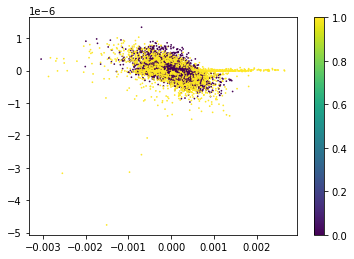

In [91]:
plt.scatter(integrated_heating, integrated_moistening, c=is_novelty, s=0.5)
plt.colorbar()
plt.show()

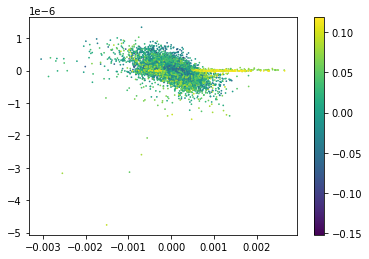

In [109]:
plt.scatter(integrated_heating, integrated_moistening, c=centered_score, s=0.5)
plt.colorbar()
plt.show()

In [92]:
print(integrated_heating.mean().values)
print(integrated_moistening.mean().values)

8.52998e-05
-3.6899552e-09


In [93]:
print(xr.ufuncs.fabs(integrated_heating).mean().values)
print(xr.ufuncs.fabs(integrated_moistening).mean().values)


0.00027655877
1.3555808e-07


In [94]:
novelty_frac = is_novelty.mean().values

In [102]:
is_novelty + integrated_heating

<xarray.DataArray (tile: 6, y: 48, x: 48)>
dask.array<add, shape=(6, 48, 48), dtype=float64, chunksize=(6, 48, 48), chunktype=numpy.ndarray>
Coordinates:
  * tile     (tile) int64 0 1 2 3 4 5
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 ... 38 39 40 41 42 43 44 45 46 47
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 ... 38 39 40 41 42 43 44 45 46 47
    time     object 2020-09-15 06:00:00

In [101]:
integrated_heating

<xarray.DataArray 'dQ1' (tile: 6, y: 48, x: 48)>
array([[[ 7.43868179e-04,  1.83731550e-04,  1.58767245e-04, ...,
          1.49594052e-04,  1.37749128e-04,  1.83447541e-04],
        [ 6.21247164e-04,  4.06588166e-04,  3.02329776e-04, ...,
          2.41134767e-04,  2.51910125e-04,  8.13260849e-05],
        [ 6.28941227e-04,  6.91777328e-04,  4.70688974e-04, ...,
          1.41961245e-05, -1.53985224e-04, -3.96530049e-05],
        ...,
        [-6.65483385e-05, -1.38751836e-03, -1.74044946e-03, ...,
          2.26499164e-04,  6.66750639e-05, -4.71147825e-04],
        [ 1.35030161e-04,  1.12625392e-04, -1.47051027e-03, ...,
          2.62502581e-04,  1.47107494e-05, -3.31901538e-05],
        [ 6.85770938e-05,  6.30789145e-05, -2.44675030e-04, ...,
          2.28098812e-04,  1.30172411e-04,  1.43184210e-04]],

       [[ 1.76540460e-04,  1.70250220e-04,  1.13282244e-04, ...,
          1.92151565e-05,  1.04285980e-04,  1.54217676e-04],
        [-4.00808603e-05, -2.29192083e-05, -6.49536742e-05, ...,
         -1.71001811e-05, -3.92372676e-05, -2.00575596e-06],
        [ 9.49699897e-05,  1.30432643e-04, -1.40392040e-05, ...,
          2.05263685e-04,  1.52848515e-04,  1.91672676e-04],
...
          3.62932595e-04,  4.83457436e-04,  4.19268123e-04],
        [-3.27333953e-04, -4.46249265e-04, -1.07275482e-04, ...,
          6.65082189e-04,  8.13338673e-04,  4.25611594e-04],
        [-1.01370191e-04,  4.31493427e-05, -1.86326084e-04, ...,
          7.02317338e-04,  7.96720502e-04,  8.01804184e-04]],

       [[ 1.13026777e-04,  9.65608779e-05,  1.20101606e-04, ...,
          2.07487290e-04,  2.04837241e-04,  1.24106722e-04],
        [ 6.61244048e-05,  6.17529440e-05,  5.17276058e-05, ...,
          1.32254558e-04,  1.15136412e-04,  1.73704262e-04],
        [ 1.25684473e-05,  2.47612188e-05,  3.34518700e-06, ...,
          1.45876576e-04,  1.46449151e-04,  1.29333319e-04],
        ...,
        [ 4.14738490e-04,  1.56183058e-04,  2.41715476e-04, ...,
          5.26528456e-05,  1.54192006e-04,  1.34428905e-04],
        [ 1.74006505e-04,  2.33455823e-04,  2.60975241e-04, ...,
          4.57178030e-05,  1.44176651e-04,  1.49584084e-04],
        [ 3.25239700e-04,  1.68505780e-04,  1.80139119e-04, ...,
          1.45738624e-04,  1.20646160e-04,  1.10941764e-04]]],
      dtype=float32)
Coordinates:
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 ... 38 39 40 41 42 43 44 45 46 47
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 ... 38 39 40 41 42 43 44 45 46 47
    time     object 2020-09-15 06:00:00
  * tile     (tile) int64 0 1 2 3 4 5

In [104]:
print((is_novelty * integrated_heating).mean().values * novelty_frac)
print((is_novelty * integrated_moistening).mean().values * novelty_frac)
print(((1 - is_novelty) * integrated_heating).mean().values * (1 - novelty_frac))
print(((1 - is_novelty) * integrated_moistening).mean().values * (1 - novelty_frac))


3.0444462235571557e-05
-2.0217100165911446e-09
1.3822529587493427e-05
-1.3047457314519058e-10


In [106]:
print(xr.ufuncs.fabs(is_novelty * integrated_heating).mean().values * novelty_frac)
print(xr.ufuncs.fabs(is_novelty * integrated_moistening).mean().values * novelty_frac)
print(xr.ufuncs.fabs((1 - is_novelty) * integrated_heating).mean().values * (1 - novelty_frac))
print(xr.ufuncs.fabs((1 - is_novelty) * integrated_moistening).mean().values * (1 - novelty_frac))


0.0001040637547906365
4.9600243442015497e-08
4.1261997673897926e-05
2.115874165590582e-08


## Recreated model crash analysis

In [3]:
prognostic_data = xr.open_zarr(fsspec.get_mapper(os.path.join(runs["prognostic"]["url"], 'state_after_timestep.zarr')))
baseline_data = xr.open_zarr(fsspec.get_mapper(os.path.join(runs["baseline"]["url"], 'state_after_timestep.zarr')))
training_data_url = "gs://vcm-ml-experiments/n2f-pire-sfc-updates/2022-01-21/nudged-run/fv3gfs_run/reference_state.zarr"
training_data = xr.open_zarr(fsspec.get_mapper(training_data_url))

/home/claytons/miniconda3/envs/fv3net/lib/python3.8/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [4]:
# restrict both datasets to time of prognostic crash
start_time = prognostic_data.time.min().item()
end_time = prognostic_data.time.max().item()
baseline_data = baseline_data.sel(time=slice(start_time, end_time))
training_data = training_data.sel(time=slice(start_time, end_time))

In [5]:
common_coords = {"tile": range(6), "x": range(48), "y": range(48)}
grid =  catalog["grid/c48"].read().assign_coords(common_coords)

In [6]:
def time_sample(dataset, num_times):
    return dataset.isel(time=np.random.choice(range(dataset.time.size), size=num_times, replace=False)).sortby("time")
baseline_sample = time_sample(baseline_data, 100)
training_sample = time_sample(training_data, 100)
baseline_sample_coarse = time_sample(baseline_data, 10)
training_sample_coarse = time_sample(training_data, 10)
prognostic_sample_coarse = time_sample(prognostic_data, 10)

[########################################] | 100% Completed | 10.4s
[########################################] | 100% Completed | 11.1s
[########################################] | 100% Completed | 12.3s
[########################################] | 100% Completed |  8.7s
[########################################] | 100% Completed |  8.5s
[########################################] | 100% Completed | 10.0s
[########################################] | 100% Completed |  8.4s
[########################################] | 100% Completed |  9.3s
[########################################] | 100% Completed |  8.8s
[########################################] | 100% Completed |  7.1s
[########################################] | 100% Completed |  8.3s
[########################################] | 100% Completed |  7.8s
[########################################] | 100% Completed |  7.9s
[########################################] | 100% Completed |  8.5s
[########################################] | 100

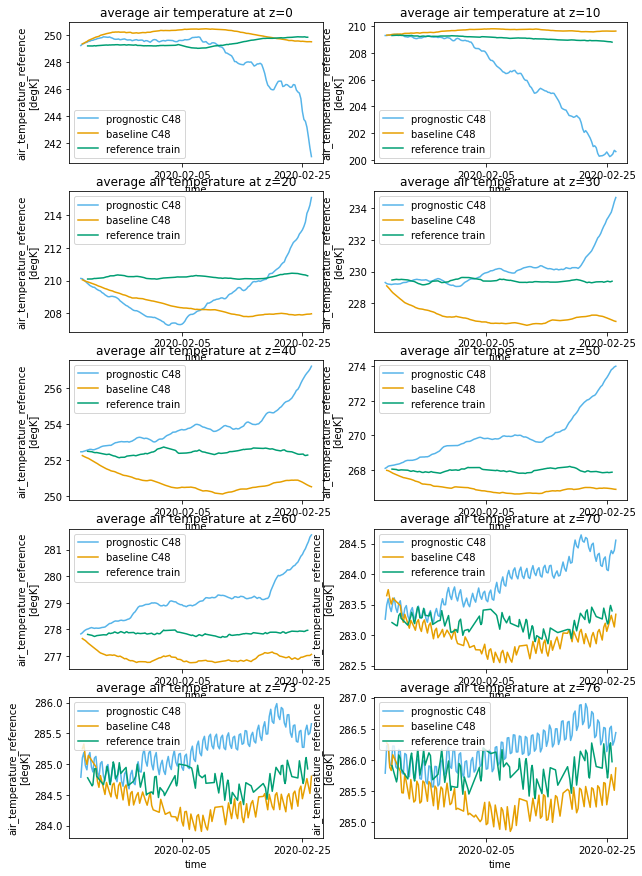

In [19]:
def timeseries_average_by_pressure_level(data_arrays, labels, attribute):
    with dask.diagnostics.ProgressBar():
        z = [0, 10, 20, 30, 40, 50, 60, 70, 73, 76]
        common_coords = {"tile": range(6), "x": range(48), "y": range(48)}
        fig, axes = plt.subplots(math.ceil(len(z) / 2), 2, figsize=(10, 15))

        for i, zi in enumerate(z):
            for da, label in zip(data_arrays, labels):
                if label is None:
                    vcm.weighted_average(da.isel(z=zi).assign_coords(common_coords), grid.area)\
                        .plot(ax=axes[i//2][i%2])
                else:
                    vcm.weighted_average(da.isel(z=zi).assign_coords(common_coords), grid.area)\
                        .plot(label=label, ax=axes[i//2][i%2])
                    axes[i//2][i%2].legend()
            axes[i//2][i%2].set_title("average {} at z={}".format(attribute, zi))
        plt.show()
        fig.tight_layout()

temp_data_arrays = [
    prognostic_data.air_temperature,
    baseline_sample.air_temperature,
    training_sample.air_temperature_reference
]
labels = ['prognostic C48', 'baseline C48', 'reference train']
timeseries_average_by_pressure_level(temp_data_arrays, labels, "air temperature")


[########################################] | 100% Completed | 21.3s
[########################################] | 100% Completed | 21.8s
[########################################] | 100% Completed | 20.9s
[########################################] | 100% Completed | 20.0s
[########################################] | 100% Completed | 21.8s
[########################################] | 100% Completed | 24.7s
[########################################] | 100% Completed | 20.7s
[########################################] | 100% Completed | 21.9s
[########################################] | 100% Completed | 19.7s
[########################################] | 100% Completed | 19.8s


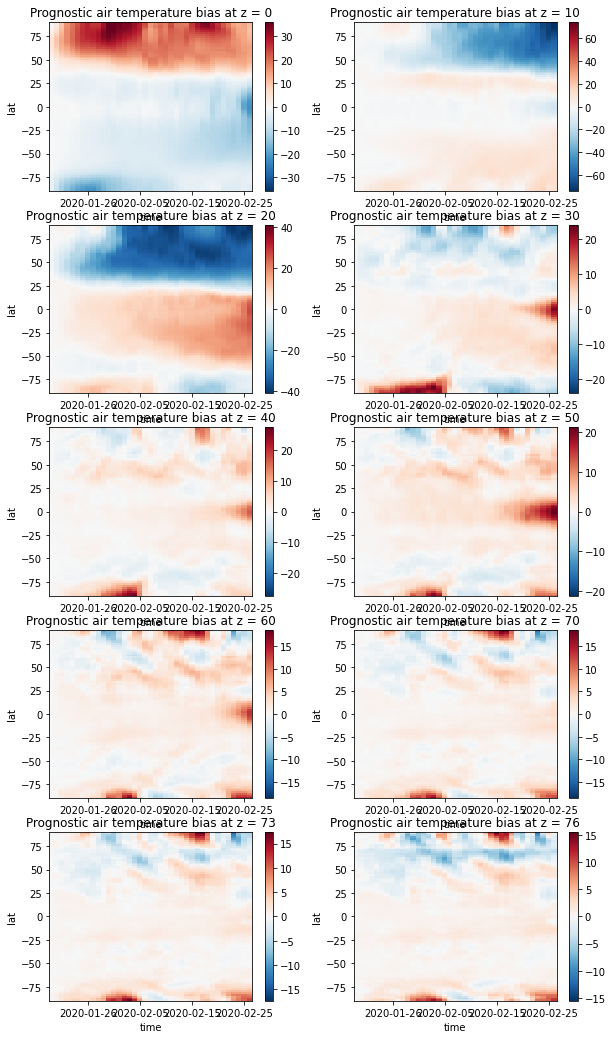

In [20]:
def timeseries_average_by_latitude_pressure_level(arr, title):
    with dask.diagnostics.ProgressBar():
        z = [0, 10, 20, 30, 40, 50, 60, 70, 73, 76]
        fig, axes = plt.subplots(math.ceil(len(z) / 2), 2, figsize=(10, 18))

        for i, zi in enumerate(z):
            vcm.zonal_average_approximate(grid.lat, arr.isel(z=zi)).plot(x="time", ax=axes[i//2][i%2])
            axes[i//2][i%2].set_title("{} at z = {}".format(title, zi))
        plt.show()
        fig.tight_layout()

def timeseries_average_bias_by_latitude_pressure_level(prognostic_data_array, reference_data_array, attribute):
    common_coords = {"tile": range(6), "x": range(48), "y": range(48)}
    bias = (
        prognostic_data_array.resample(time="1D").mean().assign_coords(common_coords)
        - reference_data_array.resample(time="1D").mean().assign_coords(common_coords)
    )
    timeseries_average_by_latitude_pressure_level(bias, "Prognostic {} bias".format(attribute))

timeseries_average_bias_by_latitude_pressure_level(
    prognostic_data.air_temperature,
    training_data.air_temperature_reference,
    "air temperature")

[########################################] | 100% Completed | 14.0s


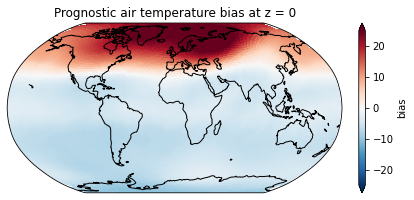

[########################################] | 100% Completed | 14.4s


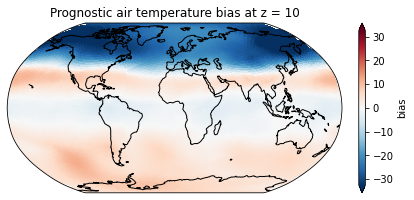

[########################################] | 100% Completed | 14.2s


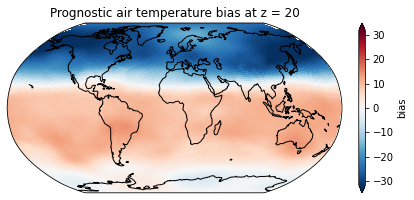

[########################################] | 100% Completed | 14.0s


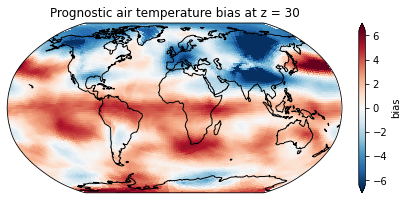

[########################################] | 100% Completed | 14.5s


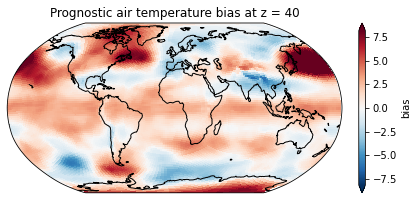

[########################################] | 100% Completed | 13.8s


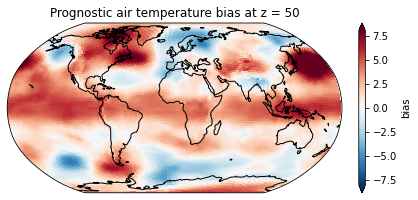

[########################################] | 100% Completed | 13.4s


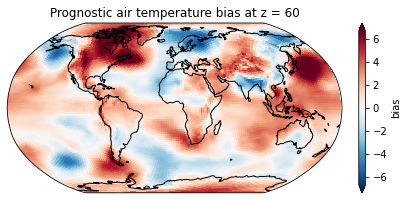

[########################################] | 100% Completed | 13.2s


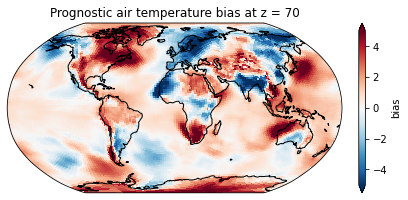

[########################################] | 100% Completed | 16.2s


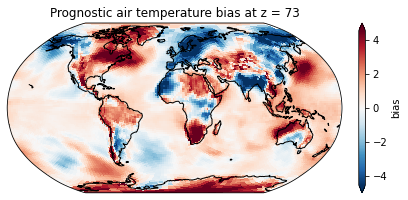

[########################################] | 100% Completed | 16.4s


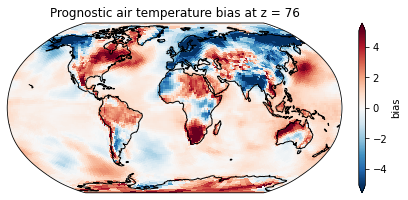

In [21]:
def average_map_by_pressure_level(arr, title, name):
    with dask.diagnostics.ProgressBar():
        z = [0, 10, 20, 30, 40, 50, 60, 70, 73, 76]
        common_coords = {"tile": range(6), "x": range(48), "y": range(48)}

        for i, zi in enumerate(z):
            arr_ds = arr.isel(z=zi).load().to_dataset(name=name).merge(grid).assign_coords(common_coords)
            fv3viz.plot_cube(ds = arr_ds, var_name=name)
            plt.title("{} at z = {}".format(title, zi))
            plt.show()
    
def average_bias_map_by_pressure_level(prognostic_data_array, reference_data_array, attribute):
    bias = prognostic_data_array.mean("time") - reference_data_array.mean("time")
    average_map_by_pressure_level(bias, "Prognostic {} bias".format(attribute), "bias")

average_bias_map_by_pressure_level(
    prognostic_data.air_temperature,
    training_sample.air_temperature_reference,
    "air temperature")


In [7]:
ocsvm_humidity_large_gamma_path = "gs://vcm-ml-experiments/claytons/2022-08-09/tq-combined-nd-trial-1/trained_models/ocsvm-larger-gamma"


In [8]:
import hashlib

def get_offline_diags(novelty_detector, nd_path, testing_ds, testing_ds_name: str) -> xr.Dataset:
    """
    Returns a dataset containing the is_novelty and novelty_score fields that reflect
    the offline behavior of a novelty detector on some other temporal dataset.
    """
    diags_url = os.path.join(
        nd_path,
        f"diags_novelty_offline_truncated/{hashlib.md5(testing_ds_name.encode()).hexdigest()}",
    )
    fs = vcm.cloud.get_fs(diags_url)
    if fs.exists(diags_url):
        print(
            f"Reading offline novelty data from "
            + f"previous computation, at {diags_url}."
        )
        diags = xr.open_zarr(fsspec.get_mapper(diags_url))
    else:
        print(f"Computing offline novelty data from states from {testing_ds_name}.")
        _, diags = novelty_detector.predict_novelties(testing_ds)
        mapper = fsspec.get_mapper(diags_url)
        diags.to_zarr(mapper, mode="w", consolidated=True)
        print(f"Saved online novelty data to {diags_url}.")
    return diags

In [42]:
from fv3fit.sklearn._ocsvm_novelty_detector import OCSVMNoveltyDetector
from fv3fit.sklearn._min_max_novelty_detector import MinMaxNoveltyDetector

def evaluate_novelty_detection_plots(score_ds, cutoff, dataset_name, full_fraction_range=False):
    novelty_ds = xr.where(score_ds > cutoff, 1, 0)
        
    score_ds.plot(bins=50, label="typical")
    plt.axvline(x=cutoff, c="r")
    plt.title("Histogram of OCSVM scores for {} data".format(dataset_name))
    plt.show()

    novelty_ds.mean(("tile", "x", "y")).plot(label="cutoff")
    plt.title("Fraction of novelties by time")
    plt.show()

    # novelty_ds.mean(("tile", "x", "y")).plot(label="cutoff")
    # xr.where(score_ds > 2 * cutoff, 1, 0).mean(("tile", "x", "y")).plot(label="2*cutoff")
    # xr.where(score_ds > cutoff / 2, 1, 0).mean(("tile", "x", "y")).plot(label="cutoff/2")
    # plt.legend()
    # plt.title("Fraction of novelties by time with other cutoffs")
    # plt.show()

    if full_fraction_range:
        vcm.zonal_average_approximate(
            grid.lat,
            novelty_ds
        ).plot(x="time", vmax=1, vmin=0)
    else:
        vcm.zonal_average_approximate(
            grid.lat,
            novelty_ds
        ).plot(x="time")
    plt.title("Fraction of novelties by time and latitude")
    plt.show()

    if full_fraction_range:
        fv3viz.plot_cube(ds = novelty_ds.mean("time").to_dataset(name="novelty_frac").merge(grid), var_name="novelty_frac", vmax=1, vmin=0)
    else:
        fv3viz.plot_cube(ds = novelty_ds.mean("time").to_dataset(name="novelty_frac").merge(grid), var_name="novelty_frac", cmap_percentiles_lim=False)
    plt.title("Fraction of novelties over time")
    plt.show()

    print("Total fraction of novelties: {}".format(novelty_ds.mean().load()))


def eval_ocsvm(
    nd_path,
    cutoff,
    testing_dataset_name,
    testing_data,
    save_model=True,
    timer=True,
    is_ocsvm=True,
    full_fraction_range=False):
    if is_ocsvm:
        nd = OCSVMNoveltyDetector.load(nd_path)
    else:
        nd = MinMaxNoveltyDetector.load(nd_path)
    # centered_score, _ = ocsvm.predict_novelties(testing_data, cutoff)
    centered_score = get_offline_diags(nd, nd_path, testing_data, testing_dataset_name).centered_score
    evaluate_novelty_detection_plots(centered_score, cutoff, testing_dataset_name, full_fraction_range=full_fraction_range)
    return nd, centered_score


Computing offline novelty data from states from prognostic.
1
2
2.5
3
4
5
6
7
Saved online novelty data to gs://vcm-ml-experiments/claytons/2022-08-09/tq-combined-nd-trial-1/trained_models/ocsvm-larger-gamma/diags_novelty_offline_truncated/bc5987e3620f62a375588ce8261e81fb.


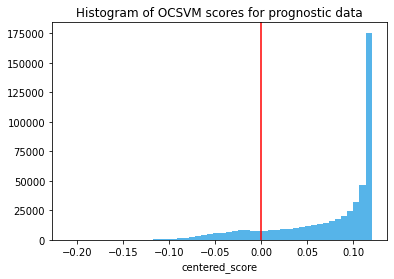

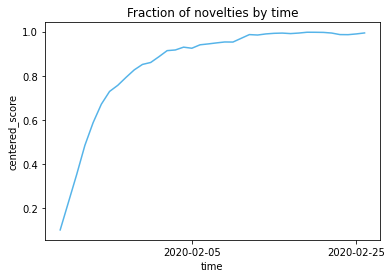

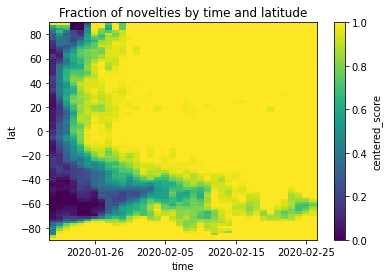

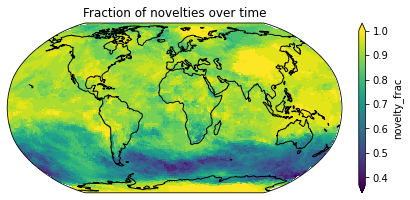

Total fraction of novelties: 0.8522497106481481


In [28]:
_, ocsvm_humidity_large_gamma_prognostic_centered_score = eval_ocsvm(
    ocsvm_humidity_large_gamma_path,
    0,
    "prognostic",
    prognostic_data.where(prognostic_data.time.dt.hour == 0, drop=True))

Computing offline novelty data from states from baseline.
1
2
2.5
3
4
5
6
7
Saved online novelty data to gs://vcm-ml-experiments/claytons/2022-08-09/tq-combined-nd-trial-1/trained_models/ocsvm-larger-gamma/diags_novelty_offline_truncated/e7e14cdcfbc59bba291688ae9cf039d6.


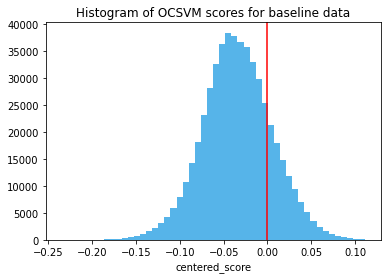

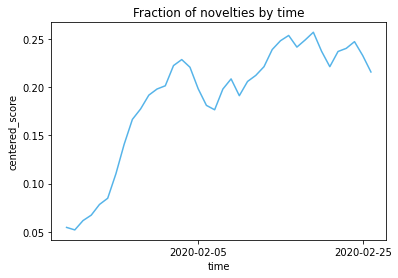

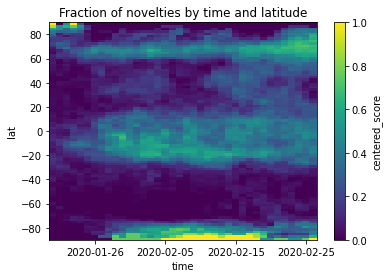

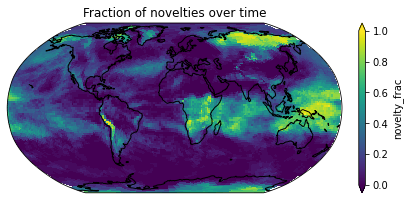

Total fraction of novelties: 0.18869738365009747


In [29]:
_, ocsvm_humidity_large_gamma_baseline_centered_score = eval_ocsvm(
    ocsvm_humidity_large_gamma_path,
    0,
    "baseline",
    baseline_data.where(baseline_data.time.dt.hour == 0, drop=True))

In [38]:
novelty_detector_paths = {
    "ocsvm_tq_large_gamma": "gs://vcm-ml-experiments/claytons/2022-08-09/tq-combined-nd-trial-1/trained_models/ocsvm-larger-gamma",
    "ocsvm_tq_default_gamma": "gs://vcm-ml-experiments/claytons/2022-07-20/tq-combined-nd-trial-2/trained_models/ocsvm",
    "minmax_tq": "gs://vcm-ml-experiments/claytons/2022-07-20/tq-combined-nd-trial-2/trained_models/minmax",
    "ocsvm_t_large_gamma": "gs://vcm-ml-experiments/claytons/2022-07-18/ocsvm-gamma-trial-1/trained_models/ocsvm-large",
    "ocsvm_t_default_gamma": "gs://vcm-ml-experiments/claytons/2022-07-15/ocsvm-default-trial-3/trained_models/ocsvm",
    "ocsvm_t_small_gamma": "gs://vcm-ml-experiments/claytons/2022-07-18/ocsvm-gamma-trial-1/trained_models/ocsvm-small",
    "minmax_t": "gs://vcm-ml-experiments/claytons/2022-07-13/oos-test/novelty"
}

novelty_detector_is_ocsvm = {
    "ocsvm_tq_large_gamma": True,
    "ocsvm_tq_default_gamma": True,
    "minmax_tq": False,
    "ocsvm_t_large_gamma": True,
    "ocsvm_t_default_gamma": True,
    "ocsvm_t_small_gamma": True,
    "minmax_t": False
}

ocsvm_tq_large_gamma
prognostic
Reading offline novelty data from previous computation, at gs://vcm-ml-experiments/claytons/2022-08-09/tq-combined-nd-trial-1/trained_models/ocsvm-larger-gamma/diags_novelty_offline_truncated/bc5987e3620f62a375588ce8261e81fb.


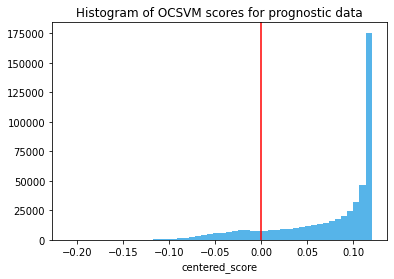

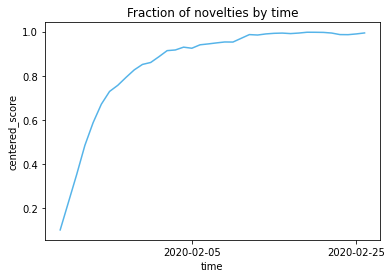

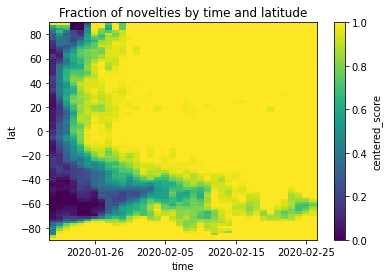

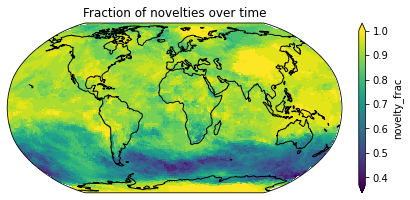

Total fraction of novelties: <xarray.DataArray 'centered_score' ()>
array(0.85224971)
baseline
Reading offline novelty data from previous computation, at gs://vcm-ml-experiments/claytons/2022-08-09/tq-combined-nd-trial-1/trained_models/ocsvm-larger-gamma/diags_novelty_offline_truncated/e7e14cdcfbc59bba291688ae9cf039d6.


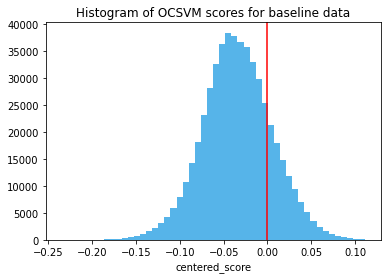

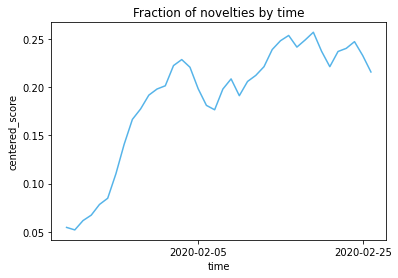

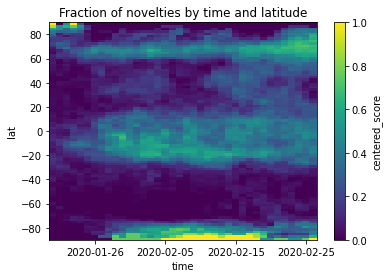

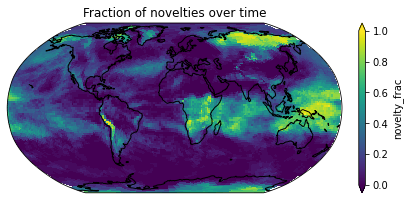

Total fraction of novelties: <xarray.DataArray 'centered_score' ()>
array(0.18869738)
ocsvm_tq_default_gamma
prognostic
Reading offline novelty data from previous computation, at gs://vcm-ml-experiments/claytons/2022-07-20/tq-combined-nd-trial-2/trained_models/ocsvm/diags_novelty_offline_truncated/bc5987e3620f62a375588ce8261e81fb.


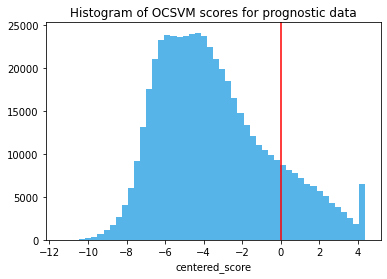

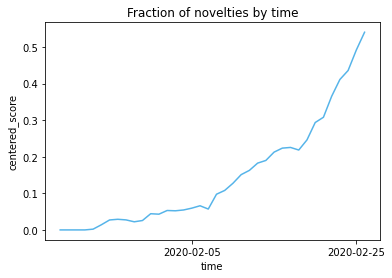

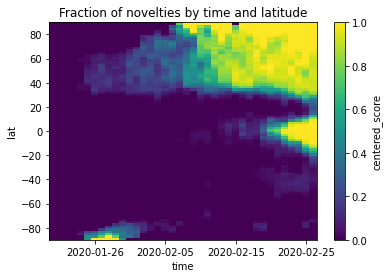

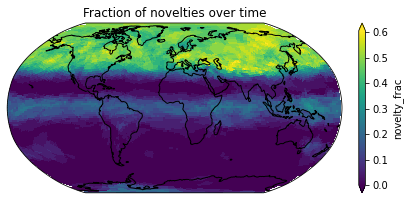

Total fraction of novelties: <xarray.DataArray 'centered_score' ()>
array(0.14661001)
baseline
Reading offline novelty data from previous computation, at gs://vcm-ml-experiments/claytons/2022-07-20/tq-combined-nd-trial-2/trained_models/ocsvm/diags_novelty_offline_truncated/e7e14cdcfbc59bba291688ae9cf039d6.


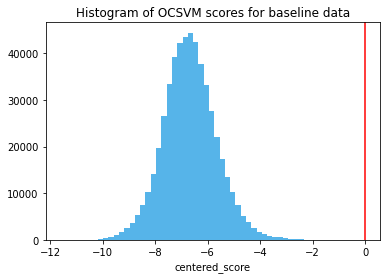

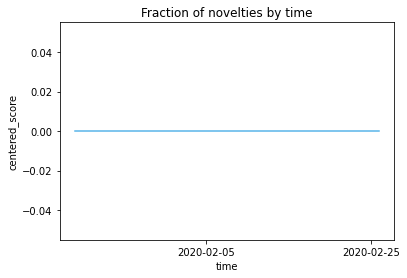

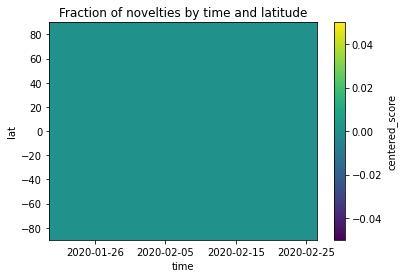

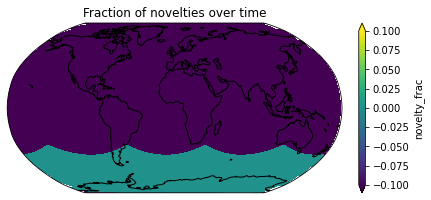

Total fraction of novelties: <xarray.DataArray 'centered_score' ()>
array(0.)
minmax_tq
prognostic
Computing offline novelty data from states from prognostic.
Saved online novelty data to gs://vcm-ml-experiments/claytons/2022-07-20/tq-combined-nd-trial-2/trained_models/minmax/diags_novelty_offline_truncated/bc5987e3620f62a375588ce8261e81fb.


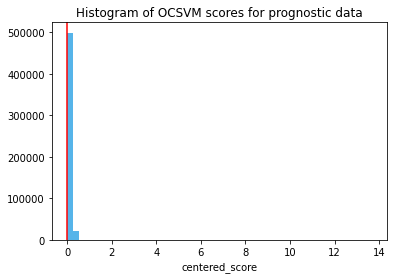

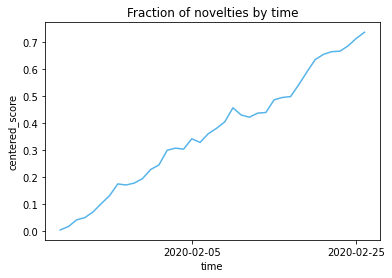

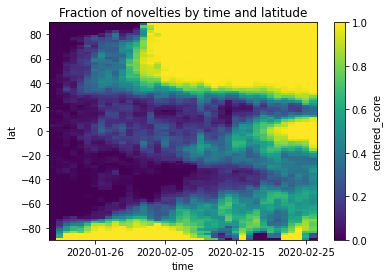

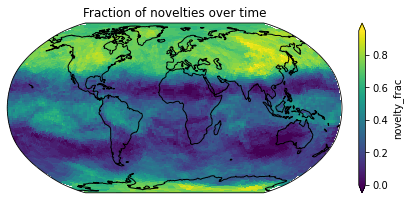

Total fraction of novelties: <xarray.DataArray 'centered_score' ()>
array(0.36536573)
baseline
Computing offline novelty data from states from baseline.
Saved online novelty data to gs://vcm-ml-experiments/claytons/2022-07-20/tq-combined-nd-trial-2/trained_models/minmax/diags_novelty_offline_truncated/e7e14cdcfbc59bba291688ae9cf039d6.


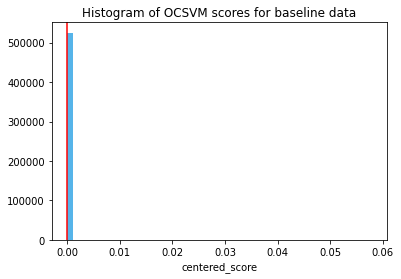

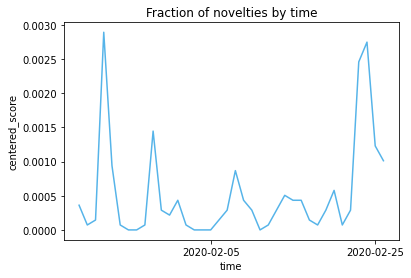

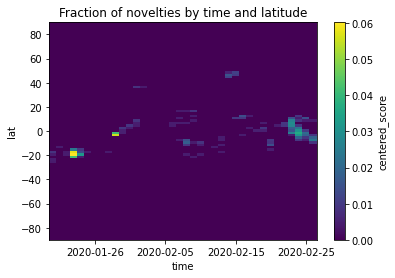

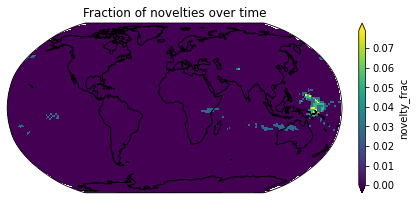

Total fraction of novelties: <xarray.DataArray 'centered_score' ()>
array(0.00051779)
ocsvm_t_large_gamma
prognostic
Computing offline novelty data from states from prognostic.
1
2
2.5
3
4
5
6
7
Saved online novelty data to gs://vcm-ml-experiments/claytons/2022-07-18/ocsvm-gamma-trial-1/trained_models/ocsvm-large/diags_novelty_offline_truncated/bc5987e3620f62a375588ce8261e81fb.


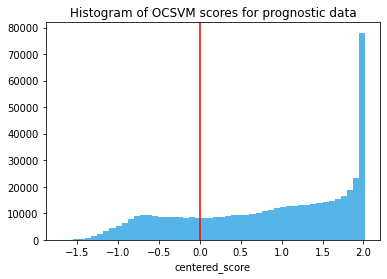

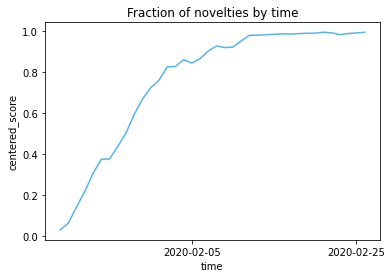

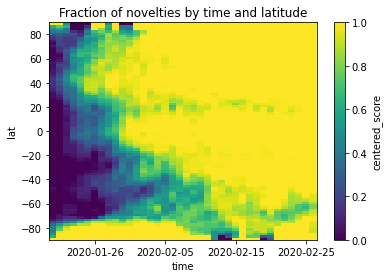

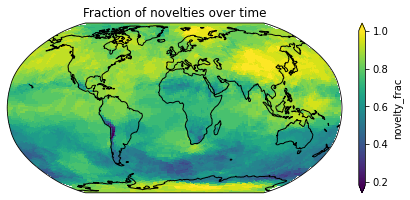

Total fraction of novelties: <xarray.DataArray 'centered_score' ()>
array(0.7578106)
baseline
Computing offline novelty data from states from baseline.
1
2
2.5
3
4
5
6
7
Saved online novelty data to gs://vcm-ml-experiments/claytons/2022-07-18/ocsvm-gamma-trial-1/trained_models/ocsvm-large/diags_novelty_offline_truncated/e7e14cdcfbc59bba291688ae9cf039d6.


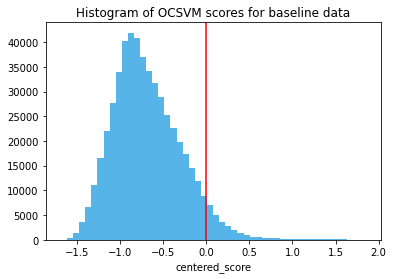

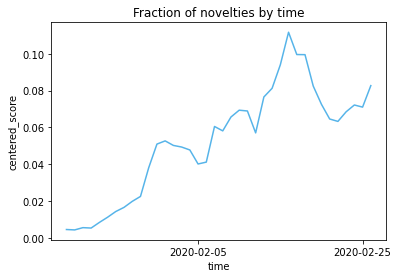

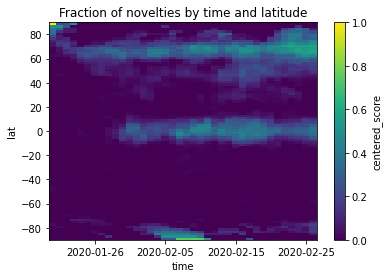

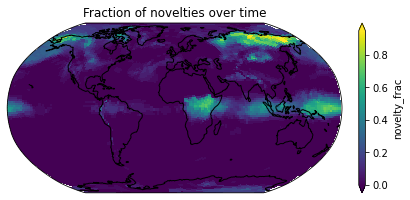

Total fraction of novelties: <xarray.DataArray 'centered_score' ()>
array(0.0527477)
ocsvm_t_default_gamma
prognostic
Computing offline novelty data from states from prognostic.
1
2
2.5
3
4
5
6
7
Saved online novelty data to gs://vcm-ml-experiments/claytons/2022-07-15/ocsvm-default-trial-3/trained_models/ocsvm/diags_novelty_offline_truncated/bc5987e3620f62a375588ce8261e81fb.


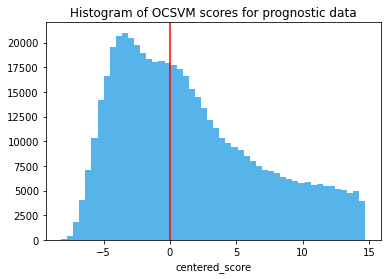

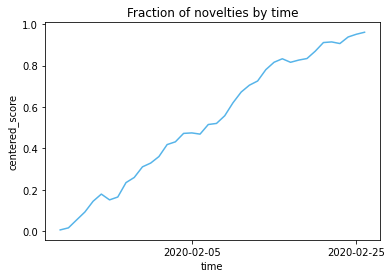

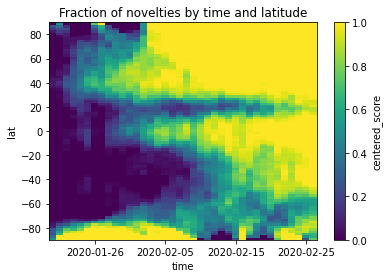

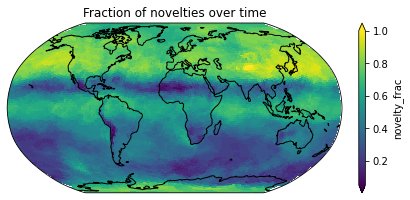

Total fraction of novelties: <xarray.DataArray 'centered_score' ()>
array(0.53309462)
baseline
Computing offline novelty data from states from baseline.
1
2
2.5
3
4
5
6
7
Saved online novelty data to gs://vcm-ml-experiments/claytons/2022-07-15/ocsvm-default-trial-3/trained_models/ocsvm/diags_novelty_offline_truncated/e7e14cdcfbc59bba291688ae9cf039d6.


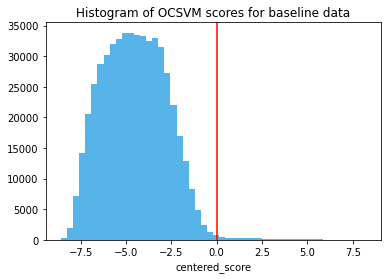

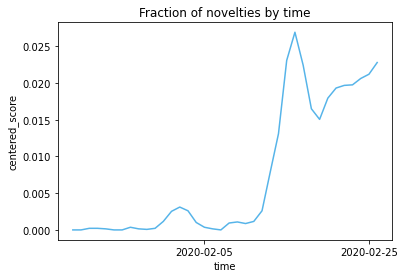

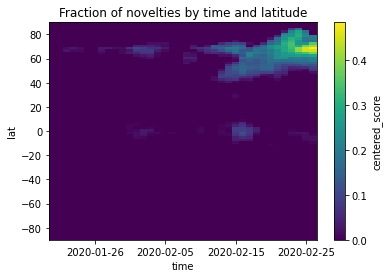

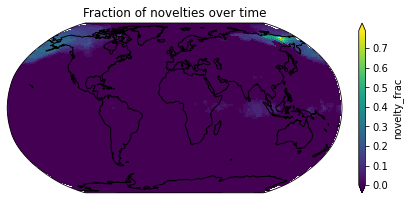

Total fraction of novelties: <xarray.DataArray 'centered_score' ()>
array(0.00750411)
ocsvm_t_small_gamma
prognostic
Computing offline novelty data from states from prognostic.
1
2
2.5
3
4
5
6
7
Saved online novelty data to gs://vcm-ml-experiments/claytons/2022-07-18/ocsvm-gamma-trial-1/trained_models/ocsvm-small/diags_novelty_offline_truncated/bc5987e3620f62a375588ce8261e81fb.


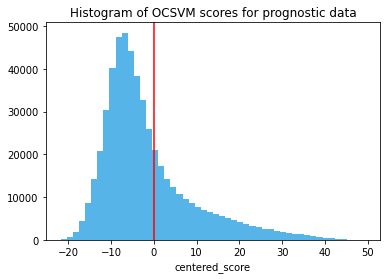

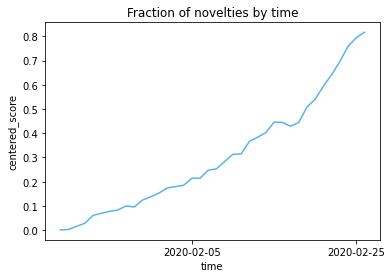

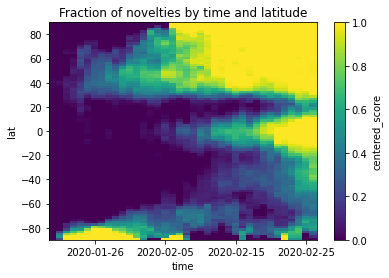

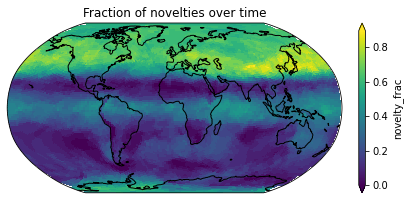

Total fraction of novelties: <xarray.DataArray 'centered_score' ()>
array(0.30514627)
baseline
Computing offline novelty data from states from baseline.
1
2
2.5
3
4
5
6
7
Saved online novelty data to gs://vcm-ml-experiments/claytons/2022-07-18/ocsvm-gamma-trial-1/trained_models/ocsvm-small/diags_novelty_offline_truncated/e7e14cdcfbc59bba291688ae9cf039d6.


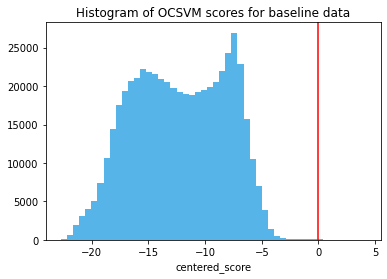

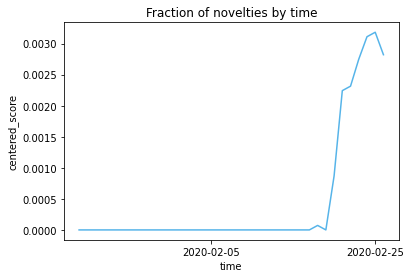

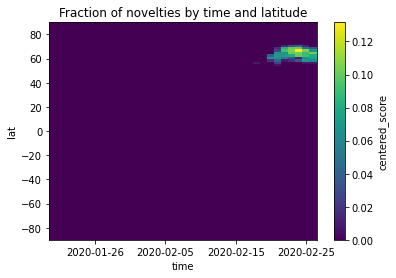

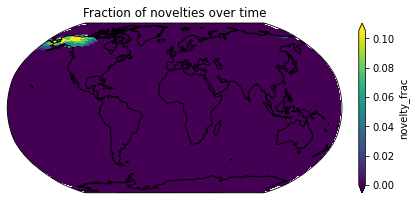

Total fraction of novelties: <xarray.DataArray 'centered_score' ()>
array(0.00045687)
minmax_t
prognostic
Computing offline novelty data from states from prognostic.
Saved online novelty data to gs://vcm-ml-experiments/claytons/2022-07-13/oos-test/novelty/diags_novelty_offline_truncated/bc5987e3620f62a375588ce8261e81fb.


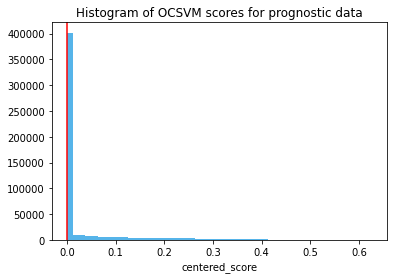

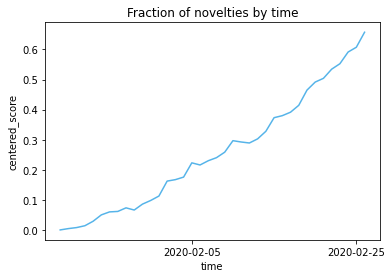

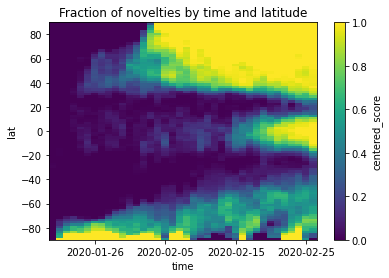

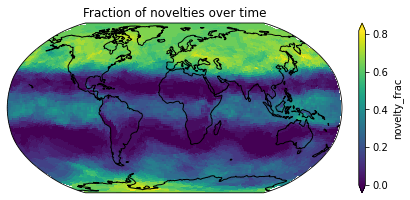

Total fraction of novelties: <xarray.DataArray 'centered_score' ()>
array(0.2581818)
baseline
Computing offline novelty data from states from baseline.
Saved online novelty data to gs://vcm-ml-experiments/claytons/2022-07-13/oos-test/novelty/diags_novelty_offline_truncated/e7e14cdcfbc59bba291688ae9cf039d6.


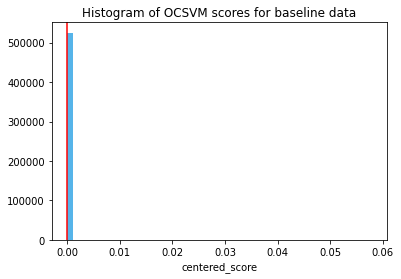

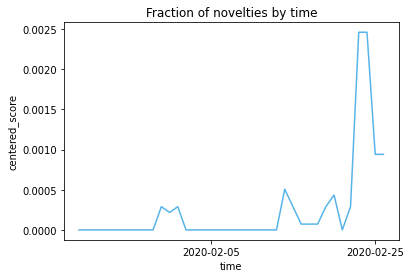

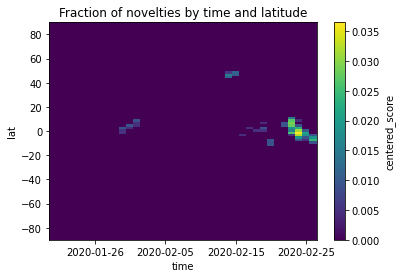

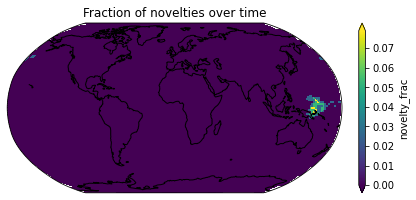

Total fraction of novelties: <xarray.DataArray 'centered_score' ()>
array(0.00025318)


In [43]:
for name, path in novelty_detector_paths.items():
    print(name)
    print("prognostic")
    eval_ocsvm(
        path,
        0,
        "prognostic",
        prognostic_data.where(prognostic_data.time.dt.hour == 0, drop=True),
        is_ocsvm = novelty_detector_is_ocsvm[name])
    print("baseline")
    eval_ocsvm(
        path,
        0,
        "baseline",
        baseline_data.where(baseline_data.time.dt.hour == 0, drop=True),
        is_ocsvm = novelty_detector_is_ocsvm[name])

